# Implementation of NLU component of a chatbot

In this assignment you will build an application that performs __intent classification__ and __slot filling__, which are the core tasks that take care the **NLU module** in any chatbot. 

*   __intent classification__ consist in mapping user utterance (typically a 
customer) into a predefined set of _intents_ (goals of the user) so the computer can know what she is asking.

* __slot filling__ consist in extracting filler values from the uterance of the user. 

The example below show a user command asking a flight ticket to fly from Boston to Denver, departing at 8:38 and arriving at 11:10. The goal is to extrac all this information automatically. 

![](https://drive.google.com/uc?export=view&id=1cWS1ybRPMGladx3qv8G4th5fyZO3cA-h)


We will use the [ATIS (Airline Travel Information Systems) dataset](https://www.aclweb.org/anthology/H90-1021.pdf), which is  a dataset consisting of audio recordings and corresponding manual transcripts about humans asking for flight information on automated airline travel inquiry systems. The data consists of 17 unique intent categories, and 81 slots in total. 

The main goal of the assigment is to build a system that perform intent detection and slot filing. We define a list steps you can folllow to complete the assignemnt. The steps are the following:
- Preprocess the data.
- Implement the models for intent classification and slot filling.
- Evaluate proposed model.
- Run some analysis of the model output.

Note you are not requiered to strictly follow the steps suggested in the notebook as long as you build a model, evaluate it and provide some analysis.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/LAP/Subjects/AP2/assignments

/content/drive/MyDrive/LAP/Subjects/AP2/assignments


In [26]:
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 401 kB 27.7 MB/s 
     |████████████████████████████████| 981 kB 44.9 MB/s 
     |████████████████████████████████| 4.2 MB 41.2 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 788 kB 51.9 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 1.6 MB 51.6 MB/s 
     |████████████████████████████████| 1.2 MB 50.8 MB/s 
     |████████████████████████████████| 19.7 MB 294 kB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 199 kB 49.8 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 6.6 MB 48.2 MB/s 
     |████████████████████████████████| 596 kB 50.3 MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-py3-none-any.whl size=116702 sha256=7cd97727855ae58

## Some utils
We provide some utilities that can be useful for the assignments. You are not obligated to use them, but depending on you model (e.g. CRF, LSTM, or BERT), it might be a good idea to use them. Also, it might faster to  

We provide two 


In [28]:
import pandas as pd

# helper function to read dev and test data format (use get_data2 for training)
def get_data(filename):
    df = pd.read_csv(filename, delim_whitespace=True, names=['word', 'label'])
    beg_indices = list(df[df['word'] == 'BOS'].index)+[df.shape[0]]
    sents, labels, intents = [], [], []
    for i in range(len(beg_indices[:-1])):
        sents.append(df[beg_indices[i]+1:beg_indices[i+1]-1]['word'].values)
        labels.append(df[beg_indices[i]+1:beg_indices[i+1]-1]['label'].values)
        intents.append(df.loc[beg_indices[i+1]-1]['label'])    
    return sents, labels, intents

# helper function to read training data format
def get_data2(filename):
    with open(filename) as f:
        contents = f.read()
    sents, labels, intents = [],[],[]
    for line in contents.strip().split('\n'):
        words, labs = [i.split(' ') for i in line.split('\t')]
        sents.append(words[1:-1])
        labels.append(labs[1:-1])
        intents.append(labs[-1])
    return sents, labels, intents

## Load the data and understand it

First thing you need to do is to understand the different aspects of the your data, such as knowing how the information is formated, the number of examples we have to train, validate and test our models, what is the distribution of labels, and so on. 

### TO-DO
Using your own code or the one provided above load the data and run some small analysis. For example, it is a good idea to print some statistics: 

- Number of examples for each partition
- Class distribution for intent classification
- Class distribution for slot filling task. 
- Do we have same set of slot labels for each intent type? 

Additionally, it is also good idea to create some plots of the statistics. 

In [29]:
data_dir="../data/atis"
train_file= data_dir + '/atis.train.w-intent.iob'
dev_file= data_dir + '/atis-2.dev.w-intent.iob'
test_file= data_dir + '/atis.test.w-intent.iob'

train_texts, train_slots, train_intents = get_data2(train_file)
dev_texts, dev_slots, dev_intents = get_data(dev_file)
test_texts, test_slots, test_intents = get_data(test_file)

In [ ]:
print(train_texts[0])
print(train_slots[0])
print(train_intents[0])

['i', 'want', 'to', 'fly', 'from', 'boston', 'at', '838', 'am', 'and', 'arrive', 'in', 'denver', 'at', '1110', 'in', 'the', 'morning']
['O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-depart_time.time', 'I-depart_time.time', 'O', 'O', 'O', 'B-toloc.city_name', 'O', 'B-arrive_time.time', 'O', 'O', 'B-arrive_time.period_of_day']
atis_flight


### Dataframe

We display dataframes with text slots and intent.

In [ ]:
train_df = pd.DataFrame({"text": train_texts, "slots": train_slots, "intent": train_intents})
train_df

,text,slots,intent
0,"[i, want, to, fly, from, boston, at, 838, am, ...","[O, O, O, O, O, B-fromloc.city_name, O, B-depa...",atis_flight
1,"[what, flights, are, available, from, pittsbur...","[O, O, O, O, O, B-fromloc.city_name, O, B-tolo...",atis_flight
2,"[what, is, the, arrival, time, in, san, franci...","[O, O, O, B-flight_time, I-flight_time, O, B-f...",atis_flight_time
3,"[cheapest, airfare, from, tacoma, to, orlando]","[B-cost_relative, O, O, B-fromloc.city_name, O...",atis_airfare
4,"[round, trip, fares, from, pittsburgh, to, phi...","[B-round_trip, I-round_trip, O, O, B-fromloc.c...",atis_airfare
...,...,...,...
4973,"[what, is, the, airfare, for, flights, from, d...","[O, O, O, O, O, O, O, B-fromloc.city_name, O, ...",atis_airfare
4974,"[do, you, have, any, flights, from, denver, to...","[O, O, O, O, O, O, B-fromloc.city_name, O, B-t...",atis_flight
4975,"[which, airlines, fly, into, and, out, of, den...","[O, O, O, O, O, O, O, B-city_name]",atis_airline
4976,"[does, continental, fly, from, boston, to, san...","[O, B-airline_name, O, O, B-fromloc.city_name,...",atis_flight


In [ ]:
dev_df = pd.DataFrame({"text": dev_texts, "slots": dev_slots, "intent": dev_intents})
dev_df

,text,slots,intent
0,"[i, want, to, fly, from, boston, at, 838, am, ...","[O, O, O, O, O, B-fromloc.city_name, O, B-depa...",atis_flight
1,"[show, me, all, round, trip, flights, between,...","[O, O, O, B-round_trip, I-round_trip, O, O, B-...",atis_flight
2,"[i, would, like, some, information, on, a, fli...","[O, O, O, O, O, O, O, O, O, B-fromloc.city_nam...",atis_flight
3,"[what, are, the, coach, flights, between, dall...","[O, O, O, B-class_type, O, O, B-fromloc.city_n...",atis_flight
4,"[i'm, flying, from, boston, to, the, bay, area]","[O, O, O, B-fromloc.city_name, O, O, B-toloc.c...",atis_flight
...,...,...,...
495,"[pm, flights, dallas, to, atlanta]","[B-depart_time.period_of_day, O, B-fromloc.cit...",atis_flight
496,"[information, on, flights, from, baltimore, to...","[O, O, O, O, B-fromloc.city_name, O, B-toloc.c...",atis_flight
497,"[what, flights, from, atlanta, to, st., louis,...","[O, O, O, B-fromloc.city_name, O, B-toloc.city...",atis_flight
498,"[show, me, ground, transportation, in, san, fr...","[O, O, O, O, O, B-city_name, I-city_name]",atis_ground_service


In [ ]:
test_df = pd.DataFrame({"text": test_texts, "slots": test_slots, "intent": test_intents})
test_df

,text,slots,intent
0,"[i, would, like, to, find, a, flight, from, ch...","[O, O, O, O, O, O, O, O, B-fromloc.city_name, ...",atis_flight
1,"[on, april, first, i, need, a, ticket, from, t...","[O, B-depart_date.month_name, B-depart_date.da...",atis_airfare
2,"[on, april, first, i, need, a, flight, going, ...","[O, B-depart_date.month_name, B-depart_date.da...",atis_flight
3,"[i, would, like, a, flight, traveling, one, wa...","[O, O, O, O, O, O, B-round_trip, I-round_trip,...",atis_flight
4,"[i, would, like, a, flight, from, orlando, to,...","[O, O, O, O, O, O, B-fromloc.city_name, O, B-t...",atis_flight
...,...,...,...
888,"[please, find, all, the, flights, from, cincin...","[O, O, O, O, O, O, B-fromloc.city_name, O, O, ...",atis_flight
889,"[find, me, a, flight, from, cincinnati, to, an...","[O, O, O, O, O, B-fromloc.city_name, O, O, O, ...",atis_flight
890,"[i'd, like, to, fly, from, miami, to, chicago,...","[O, O, O, O, O, B-fromloc.city_name, O, B-tolo...",atis_flight
891,"[i, would, like, to, book, a, round, trip, fli...","[O, O, O, O, O, O, B-round_trip, I-round_trip,...",atis_flight


### Text distribution

We display the distribution of the most common words.

In [ ]:
train_text_df = pd.Series(sum([item for item in train_df["text"]], [])).value_counts()
train_text_df

to            4308
from          3716
flights       2433
the           2095
on            1495
              ... 
823              1
capacities       1
final            1
route            1
scenario         1
Length: 898, dtype: int64

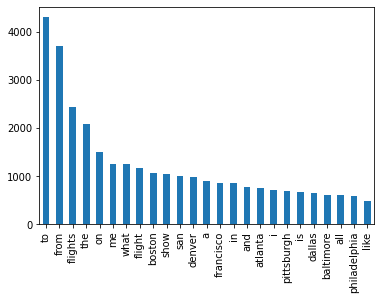

In [ ]:
train_text_df[:25].plot.bar()

### Intent distribution

We show the distribution ef intent in each set. The distribution is very unbalanced, some intents appear very few times.

In [ ]:
train_intent_df = train_df['intent'].value_counts()
train_intent_df

atis_flight                                 3666
atis_airfare                                 423
atis_ground_service                          255
atis_airline                                 157
atis_abbreviation                            147
atis_aircraft                                 81
atis_flight_time                              54
atis_quantity                                 51
atis_flight#atis_airfare                      21
atis_airport                                  20
atis_distance                                 20
atis_city                                     19
atis_ground_fare                              18
atis_capacity                                 16
atis_flight_no                                12
atis_meal                                      6
atis_restriction                               6
atis_airline#atis_flight_no                    2
atis_ground_service#atis_ground_fare           1
atis_airfare#atis_flight_time                  1
atis_cheapest       

In [ ]:
dev_intent_df = dev_df['intent'].value_counts()
dev_intent_df

atis_flight                      357
atis_airfare                      38
atis_ground_service               25
atis_airline                      18
atis_abbreviation                 17
atis_aircraft                     11
atis_quantity                     10
atis_flight_time                   9
atis_distance                      3
atis_ground_fare                   3
atis_airport                       3
atis_flight#atis_airfare           2
atis_restriction                   1
atis_capacity                      1
atis_city                          1
atis_airfare#atis_flight_time      1
Name: intent, dtype: int64

In [ ]:
test_intent_df = test_df['intent'].value_counts()
test_intent_df

atis_flight                    632
atis_airfare                    48
atis_airline                    38
atis_ground_service             36
atis_abbreviation               33
atis_capacity                   21
atis_airport                    18
atis_flight#atis_airfare        12
atis_distance                   10
atis_aircraft                    9
atis_flight_no                   8
atis_ground_fare                 7
atis_city                        6
atis_meal                        6
atis_quantity                    3
atis_day_name                    2
atis_flight_time                 1
atis_airfare#atis_flight         1
atis_flight#atis_airline         1
atis_flight_no#atis_airline      1
Name: intent, dtype: int64

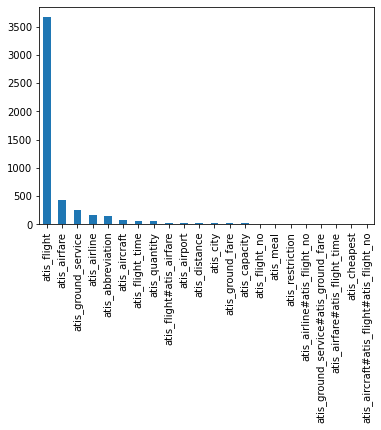

In [ ]:
train_intent_df.plot.bar()

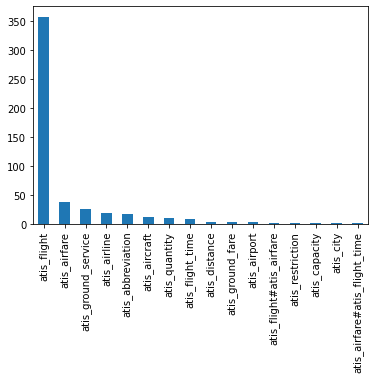

In [ ]:
dev_intent_df.plot.bar()

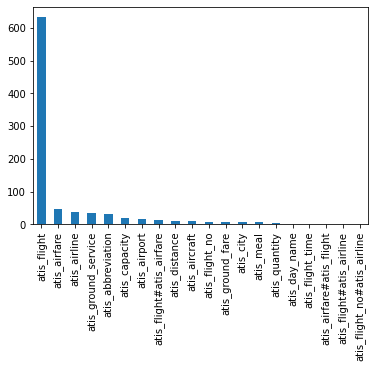

In [ ]:
test_intent_df.plot.bar()

### Slots distribution

We show the distribution ef slots in each set. The distribution is very unbalanced, some slots appear very few times. The outside (O) tag appears much more than the other tags.

In [ ]:
train_slots_df = pd.Series(sum([item for item in train_df["slots"]], []), name="slots").value_counts().to_frame()
train_slots_df

,slots
O,35669
B-toloc.city_name,4343
B-fromloc.city_name,4326
I-toloc.city_name,1099
B-depart_date.day_name,889
...,...
B-stoploc.airport_name,1
I-return_date.day_number,1
I-time,1
B-time_relative,1


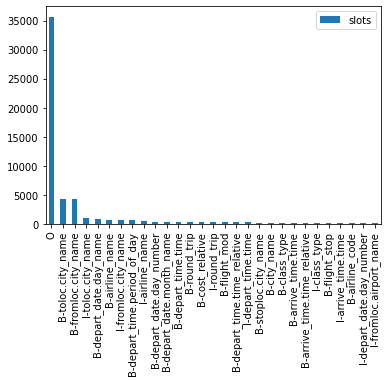

In [ ]:
train_slots_df[train_slots_df["slots"] > 100].plot.bar()

## Preprocess

As we learn in class all the NLP task require some sort of preprocessing steps. The steps vary depending on the task as well as the type model we plan to use. That is, if our choice is to train a feature based ML model, then we probably would need more than tokenization (recall that based on the preprocessing we will build our set of features). As the goal of the assignment is not to exclusively focus on preprocessing, you can start tokenizating, lemmatizing and getting the PoS of each token. For this, you can any of the existing tool for NLP such as spaCy and NLTK.

On the contrary, if we plan to use DL for modeling our tasks, than preprocessing steps can be reduced to: 
- Tokenization
- Word indexing (and creation of the vocabulary)
- Converting text to sequence of word indexes (vectorization)
- Sequence padding if needed.

In we will approach both tasks as a single sequence labelling task. So, we only need to prepare the data for the flair SequenceTagger model. Each line has a word and a tag, separated by a space. Sentences are separated with empty lines. The IOB notation is used for tags.

Development and test data are nearly in that format and only need a small change. We have to add B- to all the EOS intent tags. Train data needs to be changed because it has one sentence in each line. Changed files are saved with another name to keep the original data.

In [32]:
# helper function to change dev and test data format
def change_data(filename, filename2):
    with open(filename) as f:
        contents = f.readlines()
    with open(filename2, mode='w') as f2:
        for line in contents:
            if line != '\n':
                word, lab = line.split(' ')
                if word == "EOS":
                    f2.write(f"{word} B-{lab}")
                else:
                    f2.write(f"{word} {lab}")
            else:
                f2.write("\n")

# helper function to change training data format
def change_data2(filename, filename2):
    with open(filename) as f:
        contents = f.read()
    with open(filename2, mode='w') as f2:
        for line in contents.strip().split('\n'):
            words, labs = [i.split(' ') for i in line.split('\t')]
            for i in range(len(words) - 1):
                f2.write(f"{words[i]} {labs[i]}\n")
            f2.write(f"{words[-1]} B-{labs[-1]}\n")
            f2.write("\n")

In [33]:
train_file2 = data_dir + '/atis.train2.w-intent.iob'
dev_file2 = data_dir + '/atis.dev2.w-intent.iob'
test_file2 = data_dir + '/atis.test2.w-intent.iob'

change_data2(train_file, train_file2)
change_data(dev_file, dev_file2)
change_data(test_file, test_file2)

## Load corpus

We load the flair corpus from the previously changed files. We print the statistics of the corpus that show the sizes of each set and the counts of the tags.

In [ ]:
from flair.datasets import ColumnCorpus

# define columns
columns = {0:'text', 1:'intent-slot'}

# get the corpus
corpus = ColumnCorpus(data_folder='.', 
                      train_file=train_file2, 
                      dev_file=dev_file2, 
                      test_file=test_file2,
                      column_format=columns)

print(corpus)

2022-05-24 10:57:52,571 Reading data from .
2022-05-24 10:57:52,578 Train: ../data/atis/atis.train2.w-intent.iob
2022-05-24 10:57:52,581 Dev: ../data/atis/atis.dev2.w-intent.iob
2022-05-24 10:57:52,583 Test: ../data/atis/atis.test2.w-intent.iob
Corpus: 4978 train + 500 dev + 893 test sentences


In [ ]:
print(corpus.obtain_statistics())

{
    "TRAIN": {
        "dataset": "TRAIN",
        "total_number_of_documents": 4978,
        "number_of_documents_per_class": {
            "fromloc.city_name": 4326,
            "depart_time.time": 369,
            "toloc.city_name": 4343,
            "arrive_time.time": 208,
            "arrive_time.period_of_day": 64,
            "atis_flight": 3666,
            "depart_date.day_name": 889,
            "depart_time.period_of_day": 593,
            "flight_time": 71,
            "atis_flight_time": 54,
            "cost_relative": 344,
            "atis_airfare": 423,
            "round_trip": 348,
            "fare_amount": 53,
            "depart_date.today_relative": 84,
            "atis_aircraft": 81,
            "city_name": 227,
            "atis_ground_service": 255,
            "stoploc.city_name": 239,
            "atis_airport": 20,
            "toloc.airport_code": 20,
            "depart_time.time_relative": 323,
            "class_type": 217,
            "depart_date

## Build model

Note that in to complete the assignment you have to be able to approach the two tasks, which typically they are approached in separated manner. _Intent classification_ can be cast as __text classification__, while _slot filling_ is usually approached as a __squence labeling__ task. 
The simplest solution is to create two models, where we learn each task separately. Optionaly, you can define a joint model in which both tasks are learned at the same time.

I decided to create a single **sequence labelling** model. To do this we had to change the input data in the preprocessing step. Creating a model with flair is very simple. First, we create a dictionary with the tags. Then, we load the embeddings that we want to use. Finally, we iniatialize the SequenceTagger model.

### TO-DO

- Generate the code to build the models that are able to approach the inten classification and slot filling tasks.
- You can reused the code used in the other labs. 



### Create tag dictionary

In [40]:
# what tag do we want to predict?
tag_type = 'intent-slot'

# make the tag dictionary from the corpus
tag_dictionary = corpus.make_label_dictionary(label_type=tag_type)

2022-05-24 11:00:44,553 Computing label dictionary. Progress:


4978it [00:00, 26595.05it/s]

2022-05-24 11:00:44,755 Dictionary created for label 'intent-slot' with 102 values: toloc.city_name (seen 4343 times), fromloc.city_name (seen 4326 times), atis_flight (seen 3666 times), depart_date.day_name (seen 889 times), airline_name (seen 701 times), depart_time.period_of_day (seen 593 times), atis_airfare (seen 423 times), depart_date.day_number (seen 395 times), depart_date.month_name (seen 379 times), depart_time.time (seen 369 times), round_trip (seen 348 times), cost_relative (seen 344 times), flight_mod (seen 329 times), depart_time.time_relative (seen 323 times), atis_ground_service (seen 255 times), stoploc.city_name (seen 239 times), city_name (seen 227 times), class_type (seen 217 times), arrive_time.time (seen 208 times), arrive_time.time_relative (seen 187 times)


### Load embeddings

In [ ]:
from flair.embeddings import WordEmbeddings, StackedEmbeddings, FlairEmbeddings

# initialize embeddings
word_embedding = WordEmbeddings('glove')
flair_embedding_forward = FlairEmbeddings('en-forward')
flair_embedding_backward = FlairEmbeddings('en-backward')
embeddings = StackedEmbeddings([word_embedding, flair_embedding_forward, flair_embedding_backward])

2022-05-23 18:20:31,158 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmp3wt6ftit


100%|██████████| 160000128/160000128 [00:10<00:00, 15052930.87B/s]

2022-05-23 18:20:42,288 copying /tmp/tmp3wt6ftit to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2022-05-23 18:20:42,538 removing temp file /tmp/tmp3wt6ftit
2022-05-23 18:20:43,046 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /tmp/tmp2ddibqsn


100%|██████████| 21494764/21494764 [00:02<00:00, 9995177.85B/s] 

2022-05-23 18:20:45,708 copying /tmp/tmp2ddibqsn to cache at /root/.flair/embeddings/glove.gensim
2022-05-23 18:20:45,734 removing temp file /tmp/tmp2ddibqsn


2022-05-23 18:20:48,074 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-forward-0.4.1.pt not found in cache, downloading to /tmp/tmpnnfqqdxt


100%|██████████| 73034624/73034624 [00:05<00:00, 14382721.49B/s]

2022-05-23 18:20:53,658 copying /tmp/tmpnnfqqdxt to cache at /root/.flair/embeddings/news-forward-0.4.1.pt


2022-05-23 18:20:53,775 removing temp file /tmp/tmpnnfqqdxt
2022-05-23 18:21:07,636 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-backward-0.4.1.pt not found in cache, downloading to /tmp/tmptj51j2fs


100%|██████████| 73034575/73034575 [00:05<00:00, 14514684.57B/s]

2022-05-23 18:21:13,187 copying /tmp/tmptj51j2fs to cache at /root/.flair/embeddings/news-backward-0.4.1.pt


2022-05-23 18:21:13,320 removing temp file /tmp/tmptj51j2fs


### Initialize model

In [ ]:
# initialize sequence tagger
from flair.models import SequenceTagger
tagger: SequenceTagger = SequenceTagger(hidden_size=256,
                                        embeddings=embeddings,
                                        tag_dictionary=tag_dictionary,
                                        tag_type=tag_type,
                                        use_crf=True)

2022-05-23 18:21:13,557 SequenceTagger predicts: Dictionary with 405 tags: O, S-toloc.city_name, B-toloc.city_name, E-toloc.city_name, I-toloc.city_name, S-fromloc.city_name, B-fromloc.city_name, E-fromloc.city_name, I-fromloc.city_name, S-atis_flight, B-atis_flight, E-atis_flight, I-atis_flight, S-depart_date.day_name, B-depart_date.day_name, E-depart_date.day_name, I-depart_date.day_name, S-airline_name, B-airline_name, E-airline_name, I-airline_name, S-depart_time.period_of_day, B-depart_time.period_of_day, E-depart_time.period_of_day, I-depart_time.period_of_day, S-atis_airfare, B-atis_airfare, E-atis_airfare, I-atis_airfare, S-depart_date.day_number, B-depart_date.day_number, E-depart_date.day_number, I-depart_date.day_number, S-depart_date.month_name, B-depart_date.month_name, E-depart_date.month_name, I-depart_date.month_name, S-depart_time.time, B-depart_time.time, E-depart_time.time, I-depart_time.time, S-round_trip, B-round_trip, E-round_trip, I-round_trip, S-cost_relative, B

## Train, validate and evaluate

__Training__

Once you defined your model, and loaded and preprocessed the data, you just need to train it.  Depending on your model choice, you might need to extract the features (and vectorize the examples) before you fit your model. 

Be aware that in this phase we can explore and tune the hyperparameter values of our model. Note that we are not allowed to use the test partition for that. All the development of our approach is done on training and development paritions. 

__Evaluation__

Once you fit the model and you are happy with your results obtained in the validation part, you can move to evaluate the model on the test part. 
 Note that you have to choose a set of useful evaluation __metrics__. Typically, we use precision, recall, and f1-score, and you can use  For that you can use the functions in `sklearn.metrics` modules.  If you are using `tensorflow` or `pytorch` you can their buil-in metrics for the evaluation.

### TO-DO
- Fit and tune your model using the training and development partition.
- Make clear in the code how you tune your model. 
- Evaluate it on the test set.



### Train and evaluate model

I train the flair model for 50 epochs and achieve nearly perfect performance on development with F1 score of 0.9984 and accuracy of 0.9977. Test evaluation fails and I have not managed to fix it. I have tried multiple times, but it seems to be a flair bug. The dictionry has the unkown token and there shoulbe be no problem with unknown tokens in test. It is expected to be a very good score, taking into account the development score.

In [ ]:
# initialize trainer
from flair.trainers import ModelTrainer
trainer: ModelTrainer = ModelTrainer(tagger, corpus)

In [ ]:
trainer.train('../resources/flair-intent-slot',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=50)

/usr/local/lib/python3.7/dist-packages/flair/trainers/trainer.py:65: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  "There should be no best model saved at epoch 1 except there "


2022-05-23 18:21:14,818 ----------------------------------------------------------------------------------------------------
2022-05-23 18:21:14,823 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4196, out_features=4196, b

100%|██████████| 16/16 [00:04<00:00,  3.75it/s]


2022-05-23 18:22:45,318 Evaluating as a multi-label problem: False
2022-05-23 18:22:45,351 DEV : loss 0.5941332578659058 - f1-score (micro avg)  0.759
2022-05-23 18:22:45,388 BAD EPOCHS (no improvement): 0
2022-05-23 18:22:45,395 saving best model
2022-05-23 18:22:47,441 ----------------------------------------------------------------------------------------------------
2022-05-23 18:22:53,528 epoch 2 - iter 15/156 - loss 0.64715429 - samples/sec: 79.00 - lr: 0.100000
2022-05-23 18:22:58,544 epoch 2 - iter 30/156 - loss 0.63530468 - samples/sec: 95.76 - lr: 0.100000
2022-05-23 18:23:04,008 epoch 2 - iter 45/156 - loss 0.62169682 - samples/sec: 87.94 - lr: 0.100000
2022-05-23 18:23:09,541 epoch 2 - iter 60/156 - loss 0.59896676 - samples/sec: 86.83 - lr: 0.100000
2022-05-23 18:23:15,692 epoch 2 - iter 75/156 - loss 0.58389118 - samples/sec: 78.09 - lr: 0.100000
2022-05-23 18:23:21,223 epoch 2 - iter 90/156 - loss 0.56956079 - samples/sec: 86.84 - lr: 0.100000
2022-05-23 18:23:27,731 epo

100%|██████████| 16/16 [00:01<00:00, 11.07it/s]

2022-05-23 18:23:49,328 Evaluating as a multi-label problem: False
2022-05-23 18:23:49,356 DEV : loss 0.3409867584705353 - f1-score (micro avg)  0.8297


2022-05-23 18:23:49,400 BAD EPOCHS (no improvement): 0
2022-05-23 18:23:49,406 saving best model
2022-05-23 18:23:51,337 ----------------------------------------------------------------------------------------------------
2022-05-23 18:23:57,967 epoch 3 - iter 15/156 - loss 0.39379217 - samples/sec: 72.49 - lr: 0.100000
2022-05-23 18:24:03,646 epoch 3 - iter 30/156 - loss 0.37741741 - samples/sec: 84.64 - lr: 0.100000
2022-05-23 18:24:09,646 epoch 3 - iter 45/156 - loss 0.37941887 - samples/sec: 80.10 - lr: 0.100000
2022-05-23 18:24:14,826 epoch 3 - iter 60/156 - loss 0.37927778 - samples/sec: 92.81 - lr: 0.100000
2022-05-23 18:24:21,457 epoch 3 - iter 75/156 - loss 0.37714575 - samples/sec: 72.43 - lr: 0.100000
2022-05-23 18:24:26,642 epoch 3 - iter 90/156 - loss 0.37230000 - samples/sec: 92.64 - lr: 0.100000
2022-05-23 18:24:33,414 epoch 3 - iter 105/156 - loss 0.36190362 - samples/sec: 70.96 - lr: 0.100000
2022-05-23 18:24:39,002 epoch 3 - iter 120/156 - loss 0.35379380 - samples/se

100%|██████████| 16/16 [00:01<00:00, 11.09it/s]

2022-05-23 18:24:53,204 Evaluating as a multi-label problem: False
2022-05-23 18:24:53,232 DEV : loss 0.25020265579223633 - f1-score (micro avg)  0.8479


2022-05-23 18:24:53,271 BAD EPOCHS (no improvement): 0
2022-05-23 18:24:53,277 saving best model
2022-05-23 18:24:55,457 ----------------------------------------------------------------------------------------------------
2022-05-23 18:25:00,743 epoch 4 - iter 15/156 - loss 0.28060524 - samples/sec: 90.88 - lr: 0.100000
2022-05-23 18:25:06,968 epoch 4 - iter 30/156 - loss 0.29900166 - samples/sec: 77.17 - lr: 0.100000
2022-05-23 18:25:12,526 epoch 4 - iter 45/156 - loss 0.29540955 - samples/sec: 86.47 - lr: 0.100000
2022-05-23 18:25:18,956 epoch 4 - iter 60/156 - loss 0.29059516 - samples/sec: 74.69 - lr: 0.100000
2022-05-23 18:25:25,901 epoch 4 - iter 75/156 - loss 0.28174986 - samples/sec: 69.17 - lr: 0.100000
2022-05-23 18:25:32,620 epoch 4 - iter 90/156 - loss 0.27737806 - samples/sec: 71.47 - lr: 0.100000
2022-05-23 18:25:37,479 epoch 4 - iter 105/156 - loss 0.27369087 - samples/sec: 98.92 - lr: 0.100000
2022-05-23 18:25:42,710 epoch 4 - iter 120/156 - loss 0.27338662 - samples/se

100%|██████████| 16/16 [00:01<00:00, 11.06it/s]

2022-05-23 18:25:57,092 Evaluating as a multi-label problem: False
2022-05-23 18:25:57,120 DEV : loss 0.1757902055978775 - f1-score (micro avg)  0.8938


2022-05-23 18:25:57,160 BAD EPOCHS (no improvement): 0
2022-05-23 18:25:57,166 saving best model
2022-05-23 18:25:59,600 ----------------------------------------------------------------------------------------------------
2022-05-23 18:26:05,495 epoch 5 - iter 15/156 - loss 0.25707738 - samples/sec: 81.56 - lr: 0.100000
2022-05-23 18:26:11,945 epoch 5 - iter 30/156 - loss 0.23938374 - samples/sec: 74.48 - lr: 0.100000
2022-05-23 18:26:16,926 epoch 5 - iter 45/156 - loss 0.23944692 - samples/sec: 96.48 - lr: 0.100000
2022-05-23 18:26:22,603 epoch 5 - iter 60/156 - loss 0.22859975 - samples/sec: 84.60 - lr: 0.100000
2022-05-23 18:26:29,157 epoch 5 - iter 75/156 - loss 0.23232276 - samples/sec: 73.27 - lr: 0.100000
2022-05-23 18:26:35,525 epoch 5 - iter 90/156 - loss 0.22870355 - samples/sec: 75.41 - lr: 0.100000
2022-05-23 18:26:40,994 epoch 5 - iter 105/156 - loss 0.22682193 - samples/sec: 87.87 - lr: 0.100000
2022-05-23 18:26:47,244 epoch 5 - iter 120/156 - loss 0.22122772 - samples/se

100%|██████████| 16/16 [00:01<00:00, 11.24it/s]

2022-05-23 18:27:01,221 Evaluating as a multi-label problem: False
2022-05-23 18:27:01,248 DEV : loss 0.1441780924797058 - f1-score (micro avg)  0.9025


2022-05-23 18:27:01,290 BAD EPOCHS (no improvement): 0
2022-05-23 18:27:01,296 saving best model
2022-05-23 18:27:03,137 ----------------------------------------------------------------------------------------------------
2022-05-23 18:27:09,496 epoch 6 - iter 15/156 - loss 0.19677053 - samples/sec: 75.59 - lr: 0.100000
2022-05-23 18:27:14,611 epoch 6 - iter 30/156 - loss 0.18956601 - samples/sec: 93.91 - lr: 0.100000
2022-05-23 18:27:19,786 epoch 6 - iter 45/156 - loss 0.18602958 - samples/sec: 92.84 - lr: 0.100000
2022-05-23 18:27:26,071 epoch 6 - iter 60/156 - loss 0.18928510 - samples/sec: 76.45 - lr: 0.100000
2022-05-23 18:27:31,018 epoch 6 - iter 75/156 - loss 0.18996312 - samples/sec: 97.22 - lr: 0.100000
2022-05-23 18:27:36,397 epoch 6 - iter 90/156 - loss 0.18861233 - samples/sec: 89.31 - lr: 0.100000
2022-05-23 18:27:43,595 epoch 6 - iter 105/156 - loss 0.19055263 - samples/sec: 66.72 - lr: 0.100000
2022-05-23 18:27:50,268 epoch 6 - iter 120/156 - loss 0.19041079 - samples/se

100%|██████████| 16/16 [00:01<00:00, 11.03it/s]

2022-05-23 18:28:04,758 Evaluating as a multi-label problem: False
2022-05-23 18:28:04,791 DEV : loss 0.12182314693927765 - f1-score (micro avg)  0.9236


2022-05-23 18:28:04,838 BAD EPOCHS (no improvement): 0
2022-05-23 18:28:04,845 saving best model
2022-05-23 18:28:06,566 ----------------------------------------------------------------------------------------------------
2022-05-23 18:28:13,177 epoch 7 - iter 15/156 - loss 0.16404043 - samples/sec: 72.69 - lr: 0.100000
2022-05-23 18:28:18,739 epoch 7 - iter 30/156 - loss 0.15561735 - samples/sec: 86.45 - lr: 0.100000
2022-05-23 18:28:24,538 epoch 7 - iter 45/156 - loss 0.15952303 - samples/sec: 82.88 - lr: 0.100000
2022-05-23 18:28:31,088 epoch 7 - iter 60/156 - loss 0.15697639 - samples/sec: 73.33 - lr: 0.100000
2022-05-23 18:28:35,982 epoch 7 - iter 75/156 - loss 0.15703340 - samples/sec: 98.21 - lr: 0.100000
2022-05-23 18:28:41,590 epoch 7 - iter 90/156 - loss 0.16079949 - samples/sec: 85.63 - lr: 0.100000
2022-05-23 18:28:47,010 epoch 7 - iter 105/156 - loss 0.16071434 - samples/sec: 88.64 - lr: 0.100000
2022-05-23 18:28:53,461 epoch 7 - iter 120/156 - loss 0.16023411 - samples/se

100%|██████████| 16/16 [00:01<00:00, 11.13it/s]

2022-05-23 18:29:08,779 Evaluating as a multi-label problem: False
2022-05-23 18:29:08,807 DEV : loss 0.09583745151758194 - f1-score (micro avg)  0.939


2022-05-23 18:29:08,847 BAD EPOCHS (no improvement): 0
2022-05-23 18:29:08,853 saving best model
2022-05-23 18:29:10,727 ----------------------------------------------------------------------------------------------------
2022-05-23 18:29:16,646 epoch 8 - iter 15/156 - loss 0.13685032 - samples/sec: 81.15 - lr: 0.100000
2022-05-23 18:29:23,350 epoch 8 - iter 30/156 - loss 0.14193961 - samples/sec: 71.64 - lr: 0.100000
2022-05-23 18:29:29,706 epoch 8 - iter 45/156 - loss 0.14378639 - samples/sec: 75.57 - lr: 0.100000
2022-05-23 18:29:36,129 epoch 8 - iter 60/156 - loss 0.14571939 - samples/sec: 74.90 - lr: 0.100000
2022-05-23 18:29:41,528 epoch 8 - iter 75/156 - loss 0.14594821 - samples/sec: 88.95 - lr: 0.100000
2022-05-23 18:29:47,535 epoch 8 - iter 90/156 - loss 0.14487425 - samples/sec: 79.96 - lr: 0.100000
2022-05-23 18:29:53,186 epoch 8 - iter 105/156 - loss 0.14376324 - samples/sec: 85.01 - lr: 0.100000
2022-05-23 18:29:58,355 epoch 8 - iter 120/156 - loss 0.14238219 - samples/se

100%|██████████| 16/16 [00:01<00:00, 10.93it/s]

2022-05-23 18:30:13,753 Evaluating as a multi-label problem: False
2022-05-23 18:30:13,783 DEV : loss 0.08674491941928864 - f1-score (micro avg)  0.9484


2022-05-23 18:30:13,825 BAD EPOCHS (no improvement): 0
2022-05-23 18:30:13,832 saving best model
2022-05-23 18:30:15,794 ----------------------------------------------------------------------------------------------------
2022-05-23 18:30:21,161 epoch 9 - iter 15/156 - loss 0.13324346 - samples/sec: 89.60 - lr: 0.100000
2022-05-23 18:30:26,822 epoch 9 - iter 30/156 - loss 0.14074820 - samples/sec: 84.85 - lr: 0.100000
2022-05-23 18:30:32,626 epoch 9 - iter 45/156 - loss 0.14056000 - samples/sec: 82.81 - lr: 0.100000
2022-05-23 18:30:38,216 epoch 9 - iter 60/156 - loss 0.14086005 - samples/sec: 85.94 - lr: 0.100000
2022-05-23 18:30:44,573 epoch 9 - iter 75/156 - loss 0.13406094 - samples/sec: 75.54 - lr: 0.100000
2022-05-23 18:30:50,238 epoch 9 - iter 90/156 - loss 0.13027722 - samples/sec: 84.78 - lr: 0.100000
2022-05-23 18:30:55,568 epoch 9 - iter 105/156 - loss 0.13013553 - samples/sec: 90.15 - lr: 0.100000
2022-05-23 18:31:01,833 epoch 9 - iter 120/156 - loss 0.12948873 - samples/se

100%|██████████| 16/16 [00:01<00:00, 10.91it/s]

2022-05-23 18:31:17,898 Evaluating as a multi-label problem: False
2022-05-23 18:31:17,930 DEV : loss 0.07348272204399109 - f1-score (micro avg)  0.9533


2022-05-23 18:31:17,971 BAD EPOCHS (no improvement): 0
2022-05-23 18:31:17,980 saving best model
2022-05-23 18:31:19,704 ----------------------------------------------------------------------------------------------------
2022-05-23 18:31:25,064 epoch 10 - iter 15/156 - loss 0.10664826 - samples/sec: 89.69 - lr: 0.100000
2022-05-23 18:31:30,907 epoch 10 - iter 30/156 - loss 0.11032212 - samples/sec: 82.21 - lr: 0.100000
2022-05-23 18:31:36,320 epoch 10 - iter 45/156 - loss 0.11029597 - samples/sec: 88.74 - lr: 0.100000
2022-05-23 18:31:41,744 epoch 10 - iter 60/156 - loss 0.11565416 - samples/sec: 88.58 - lr: 0.100000
2022-05-23 18:31:48,083 epoch 10 - iter 75/156 - loss 0.11667874 - samples/sec: 75.77 - lr: 0.100000
2022-05-23 18:31:54,278 epoch 10 - iter 90/156 - loss 0.11788805 - samples/sec: 77.53 - lr: 0.100000
2022-05-23 18:32:00,578 epoch 10 - iter 105/156 - loss 0.11887401 - samples/sec: 76.26 - lr: 0.100000
2022-05-23 18:32:06,511 epoch 10 - iter 120/156 - loss 0.11979856 - sa

100%|██████████| 16/16 [00:01<00:00, 10.96it/s]

2022-05-23 18:32:21,772 Evaluating as a multi-label problem: False
2022-05-23 18:32:21,801 DEV : loss 0.06238417699933052 - f1-score (micro avg)  0.962


2022-05-23 18:32:21,841 BAD EPOCHS (no improvement): 0
2022-05-23 18:32:21,845 saving best model
2022-05-23 18:32:23,550 ----------------------------------------------------------------------------------------------------
2022-05-23 18:32:28,843 epoch 11 - iter 15/156 - loss 0.10583465 - samples/sec: 90.85 - lr: 0.100000
2022-05-23 18:32:34,266 epoch 11 - iter 30/156 - loss 0.11164556 - samples/sec: 88.60 - lr: 0.100000
2022-05-23 18:32:40,871 epoch 11 - iter 45/156 - loss 0.11053199 - samples/sec: 72.70 - lr: 0.100000
2022-05-23 18:32:47,985 epoch 11 - iter 60/156 - loss 0.10893361 - samples/sec: 67.52 - lr: 0.100000
2022-05-23 18:32:52,989 epoch 11 - iter 75/156 - loss 0.11067324 - samples/sec: 95.97 - lr: 0.100000
2022-05-23 18:32:57,953 epoch 11 - iter 90/156 - loss 0.10894765 - samples/sec: 96.78 - lr: 0.100000
2022-05-23 18:33:03,199 epoch 11 - iter 105/156 - loss 0.10952969 - samples/sec: 91.57 - lr: 0.100000
2022-05-23 18:33:09,808 epoch 11 - iter 120/156 - loss 0.10936980 - sa

100%|██████████| 16/16 [00:01<00:00, 10.93it/s]

2022-05-23 18:33:25,187 Evaluating as a multi-label problem: False
2022-05-23 18:33:25,216 DEV : loss 0.05533647909760475 - f1-score (micro avg)  0.9617


2022-05-23 18:33:25,257 BAD EPOCHS (no improvement): 1
2022-05-23 18:33:25,264 ----------------------------------------------------------------------------------------------------
2022-05-23 18:33:31,680 epoch 12 - iter 15/156 - loss 0.09418963 - samples/sec: 74.90 - lr: 0.100000
2022-05-23 18:33:37,035 epoch 12 - iter 30/156 - loss 0.09518356 - samples/sec: 89.78 - lr: 0.100000
2022-05-23 18:33:43,401 epoch 12 - iter 45/156 - loss 0.10335593 - samples/sec: 75.51 - lr: 0.100000
2022-05-23 18:33:48,986 epoch 12 - iter 60/156 - loss 0.10265821 - samples/sec: 86.00 - lr: 0.100000
2022-05-23 18:33:55,390 epoch 12 - iter 75/156 - loss 0.10283765 - samples/sec: 75.00 - lr: 0.100000
2022-05-23 18:34:00,830 epoch 12 - iter 90/156 - loss 0.10028601 - samples/sec: 88.32 - lr: 0.100000
2022-05-23 18:34:06,974 epoch 12 - iter 105/156 - loss 0.09952303 - samples/sec: 78.19 - lr: 0.100000
2022-05-23 18:34:12,522 epoch 12 - iter 120/156 - loss 0.10197039 - samples/sec: 86.59 - lr: 0.100000
2022-05-23

100%|██████████| 16/16 [00:01<00:00, 11.05it/s]

2022-05-23 18:34:27,121 Evaluating as a multi-label problem: False
2022-05-23 18:34:27,150 DEV : loss 0.05161365121603012 - f1-score (micro avg)  0.967


2022-05-23 18:34:27,190 BAD EPOCHS (no improvement): 0
2022-05-23 18:34:27,197 saving best model
2022-05-23 18:34:28,977 ----------------------------------------------------------------------------------------------------
2022-05-23 18:34:34,767 epoch 13 - iter 15/156 - loss 0.09453310 - samples/sec: 83.02 - lr: 0.100000
2022-05-23 18:34:40,645 epoch 13 - iter 30/156 - loss 0.08793402 - samples/sec: 81.71 - lr: 0.100000
2022-05-23 18:34:46,529 epoch 13 - iter 45/156 - loss 0.09090681 - samples/sec: 81.62 - lr: 0.100000
2022-05-23 18:34:52,380 epoch 13 - iter 60/156 - loss 0.09369419 - samples/sec: 82.11 - lr: 0.100000
2022-05-23 18:34:58,662 epoch 13 - iter 75/156 - loss 0.09412073 - samples/sec: 76.49 - lr: 0.100000
2022-05-23 18:35:04,840 epoch 13 - iter 90/156 - loss 0.09509679 - samples/sec: 77.82 - lr: 0.100000
2022-05-23 18:35:10,203 epoch 13 - iter 105/156 - loss 0.09654917 - samples/sec: 89.59 - lr: 0.100000
2022-05-23 18:35:16,169 epoch 13 - iter 120/156 - loss 0.09433313 - sa

100%|██████████| 16/16 [00:01<00:00, 11.05it/s]

2022-05-23 18:35:31,318 Evaluating as a multi-label problem: False
2022-05-23 18:35:31,347 DEV : loss 0.04974815994501114 - f1-score (micro avg)  0.9657


2022-05-23 18:35:31,389 BAD EPOCHS (no improvement): 1
2022-05-23 18:35:31,394 ----------------------------------------------------------------------------------------------------
2022-05-23 18:35:36,782 epoch 14 - iter 15/156 - loss 0.10073856 - samples/sec: 89.15 - lr: 0.100000
2022-05-23 18:35:41,851 epoch 14 - iter 30/156 - loss 0.09922866 - samples/sec: 94.76 - lr: 0.100000
2022-05-23 18:35:47,286 epoch 14 - iter 45/156 - loss 0.09689719 - samples/sec: 88.38 - lr: 0.100000
2022-05-23 18:35:54,997 epoch 14 - iter 60/156 - loss 0.09408706 - samples/sec: 62.28 - lr: 0.100000
2022-05-23 18:36:01,642 epoch 14 - iter 75/156 - loss 0.09034857 - samples/sec: 72.35 - lr: 0.100000
2022-05-23 18:36:07,739 epoch 14 - iter 90/156 - loss 0.09127626 - samples/sec: 78.79 - lr: 0.100000
2022-05-23 18:36:13,820 epoch 14 - iter 105/156 - loss 0.08831900 - samples/sec: 79.00 - lr: 0.100000
2022-05-23 18:36:18,820 epoch 14 - iter 120/156 - loss 0.08779999 - samples/sec: 96.15 - lr: 0.100000
2022-05-23

100%|██████████| 16/16 [00:01<00:00, 11.10it/s]

2022-05-23 18:36:32,446 Evaluating as a multi-label problem: False
2022-05-23 18:36:32,474 DEV : loss 0.042369090020656586 - f1-score (micro avg)  0.9711


2022-05-23 18:36:32,515 BAD EPOCHS (no improvement): 0
2022-05-23 18:36:32,520 saving best model
2022-05-23 18:36:34,247 ----------------------------------------------------------------------------------------------------
2022-05-23 18:36:39,541 epoch 15 - iter 15/156 - loss 0.07845801 - samples/sec: 90.88 - lr: 0.100000
2022-05-23 18:36:45,071 epoch 15 - iter 30/156 - loss 0.08943049 - samples/sec: 86.87 - lr: 0.100000
2022-05-23 18:36:50,265 epoch 15 - iter 45/156 - loss 0.08558568 - samples/sec: 92.47 - lr: 0.100000
2022-05-23 18:36:56,770 epoch 15 - iter 60/156 - loss 0.08646194 - samples/sec: 73.83 - lr: 0.100000
2022-05-23 18:37:02,949 epoch 15 - iter 75/156 - loss 0.08341775 - samples/sec: 77.74 - lr: 0.100000
2022-05-23 18:37:08,738 epoch 15 - iter 90/156 - loss 0.08257620 - samples/sec: 83.04 - lr: 0.100000
2022-05-23 18:37:14,254 epoch 15 - iter 105/156 - loss 0.08321237 - samples/sec: 87.06 - lr: 0.100000
2022-05-23 18:37:20,736 epoch 15 - iter 120/156 - loss 0.08504804 - sa

100%|██████████| 16/16 [00:01<00:00, 10.89it/s]

2022-05-23 18:37:35,926 Evaluating as a multi-label problem: False
2022-05-23 18:37:35,956 DEV : loss 0.03744125738739967 - f1-score (micro avg)  0.9751


2022-05-23 18:37:36,000 BAD EPOCHS (no improvement): 0
2022-05-23 18:37:36,008 saving best model
2022-05-23 18:37:37,700 ----------------------------------------------------------------------------------------------------
2022-05-23 18:37:44,579 epoch 16 - iter 15/156 - loss 0.07338049 - samples/sec: 69.89 - lr: 0.100000
2022-05-23 18:37:49,857 epoch 16 - iter 30/156 - loss 0.07287185 - samples/sec: 91.00 - lr: 0.100000
2022-05-23 18:37:55,513 epoch 16 - iter 45/156 - loss 0.07642249 - samples/sec: 84.93 - lr: 0.100000
2022-05-23 18:38:00,416 epoch 16 - iter 60/156 - loss 0.07517421 - samples/sec: 98.06 - lr: 0.100000
2022-05-23 18:38:05,582 epoch 16 - iter 75/156 - loss 0.07497170 - samples/sec: 92.98 - lr: 0.100000
2022-05-23 18:38:12,499 epoch 16 - iter 90/156 - loss 0.07517981 - samples/sec: 69.45 - lr: 0.100000
2022-05-23 18:38:17,691 epoch 16 - iter 105/156 - loss 0.07683406 - samples/sec: 92.51 - lr: 0.100000
2022-05-23 18:38:23,623 epoch 16 - iter 120/156 - loss 0.07756564 - sa

100%|██████████| 16/16 [00:01<00:00, 11.05it/s]

2022-05-23 18:38:39,534 Evaluating as a multi-label problem: False
2022-05-23 18:38:39,568 DEV : loss 0.038684360682964325 - f1-score (micro avg)  0.9745


2022-05-23 18:38:39,611 BAD EPOCHS (no improvement): 1
2022-05-23 18:38:39,618 ----------------------------------------------------------------------------------------------------
2022-05-23 18:38:44,258 epoch 17 - iter 15/156 - loss 0.07149987 - samples/sec: 103.55 - lr: 0.100000
2022-05-23 18:38:49,757 epoch 17 - iter 30/156 - loss 0.07107370 - samples/sec: 87.41 - lr: 0.100000
2022-05-23 18:38:56,147 epoch 17 - iter 45/156 - loss 0.07353868 - samples/sec: 75.17 - lr: 0.100000
2022-05-23 18:39:02,968 epoch 17 - iter 60/156 - loss 0.07806382 - samples/sec: 70.41 - lr: 0.100000
2022-05-23 18:39:08,410 epoch 17 - iter 75/156 - loss 0.07739863 - samples/sec: 88.28 - lr: 0.100000
2022-05-23 18:39:14,717 epoch 17 - iter 90/156 - loss 0.07540541 - samples/sec: 76.21 - lr: 0.100000
2022-05-23 18:39:20,692 epoch 17 - iter 105/156 - loss 0.07511793 - samples/sec: 80.45 - lr: 0.100000
2022-05-23 18:39:26,597 epoch 17 - iter 120/156 - loss 0.07636739 - samples/sec: 81.38 - lr: 0.100000
2022-05-2

100%|██████████| 16/16 [00:01<00:00, 10.77it/s]

2022-05-23 18:39:41,040 Evaluating as a multi-label problem: False
2022-05-23 18:39:41,069 DEV : loss 0.03235141932964325 - f1-score (micro avg)  0.9801


2022-05-23 18:39:41,111 BAD EPOCHS (no improvement): 0
2022-05-23 18:39:41,116 saving best model
2022-05-23 18:39:42,821 ----------------------------------------------------------------------------------------------------
2022-05-23 18:39:49,111 epoch 18 - iter 15/156 - loss 0.07834474 - samples/sec: 76.50 - lr: 0.100000
2022-05-23 18:39:54,492 epoch 18 - iter 30/156 - loss 0.07165733 - samples/sec: 89.26 - lr: 0.100000
2022-05-23 18:39:59,924 epoch 18 - iter 45/156 - loss 0.07048924 - samples/sec: 88.43 - lr: 0.100000
2022-05-23 18:40:05,872 epoch 18 - iter 60/156 - loss 0.07257390 - samples/sec: 80.76 - lr: 0.100000
2022-05-23 18:40:11,463 epoch 18 - iter 75/156 - loss 0.07508795 - samples/sec: 85.89 - lr: 0.100000
2022-05-23 18:40:17,477 epoch 18 - iter 90/156 - loss 0.07546106 - samples/sec: 79.86 - lr: 0.100000
2022-05-23 18:40:23,437 epoch 18 - iter 105/156 - loss 0.07293686 - samples/sec: 80.59 - lr: 0.100000
2022-05-23 18:40:29,476 epoch 18 - iter 120/156 - loss 0.07142361 - sa

100%|██████████| 16/16 [00:01<00:00, 10.77it/s]

2022-05-23 18:40:45,054 Evaluating as a multi-label problem: False
2022-05-23 18:40:45,083 DEV : loss 0.02742089331150055 - f1-score (micro avg)  0.9846


2022-05-23 18:40:45,124 BAD EPOCHS (no improvement): 0
2022-05-23 18:40:45,131 saving best model
2022-05-23 18:40:46,912 ----------------------------------------------------------------------------------------------------
2022-05-23 18:40:53,329 epoch 19 - iter 15/156 - loss 0.06682139 - samples/sec: 74.93 - lr: 0.100000
2022-05-23 18:40:59,295 epoch 19 - iter 30/156 - loss 0.06242951 - samples/sec: 80.56 - lr: 0.100000
2022-05-23 18:41:04,415 epoch 19 - iter 45/156 - loss 0.06067917 - samples/sec: 93.83 - lr: 0.100000
2022-05-23 18:41:09,491 epoch 19 - iter 60/156 - loss 0.06354653 - samples/sec: 94.63 - lr: 0.100000
2022-05-23 18:41:15,345 epoch 19 - iter 75/156 - loss 0.06335894 - samples/sec: 82.10 - lr: 0.100000
2022-05-23 18:41:21,014 epoch 19 - iter 90/156 - loss 0.06260498 - samples/sec: 84.79 - lr: 0.100000
2022-05-23 18:41:26,933 epoch 19 - iter 105/156 - loss 0.06121138 - samples/sec: 81.17 - lr: 0.100000
2022-05-23 18:41:33,172 epoch 19 - iter 120/156 - loss 0.06249528 - sa

100%|██████████| 16/16 [00:01<00:00, 10.72it/s]

2022-05-23 18:41:47,885 Evaluating as a multi-label problem: False


2022-05-23 18:41:47,921 DEV : loss 0.025702985003590584 - f1-score (micro avg)  0.9848
2022-05-23 18:41:47,966 BAD EPOCHS (no improvement): 0
2022-05-23 18:41:47,971 saving best model
2022-05-23 18:41:49,785 ----------------------------------------------------------------------------------------------------
2022-05-23 18:41:55,385 epoch 20 - iter 15/156 - loss 0.06597978 - samples/sec: 85.86 - lr: 0.100000
2022-05-23 18:42:02,071 epoch 20 - iter 30/156 - loss 0.06410812 - samples/sec: 71.85 - lr: 0.100000
2022-05-23 18:42:08,521 epoch 20 - iter 45/156 - loss 0.06302403 - samples/sec: 74.48 - lr: 0.100000
2022-05-23 18:42:14,694 epoch 20 - iter 60/156 - loss 0.06384609 - samples/sec: 77.87 - lr: 0.100000
2022-05-23 18:42:21,177 epoch 20 - iter 75/156 - loss 0.06675115 - samples/sec: 74.09 - lr: 0.100000
2022-05-23 18:42:27,362 epoch 20 - iter 90/156 - loss 0.06616551 - samples/sec: 77.65 - lr: 0.100000
2022-05-23 18:42:33,224 epoch 20 - iter 105/156 - loss 0.06550488 - samples/sec: 82.0

100%|██████████| 16/16 [00:01<00:00, 10.82it/s]

2022-05-23 18:42:51,982 Evaluating as a multi-label problem: False
2022-05-23 18:42:52,012 DEV : loss 0.024446770548820496 - f1-score (micro avg)  0.9844
2022-05-23 18:42:52,050 BAD EPOCHS (no improvement): 1
2022-05-23 18:42:52,058 ----------------------------------------------------------------------------------------------------


2022-05-23 18:42:58,949 epoch 21 - iter 15/156 - loss 0.06961020 - samples/sec: 69.70 - lr: 0.100000
2022-05-23 18:43:05,360 epoch 21 - iter 30/156 - loss 0.06444871 - samples/sec: 74.91 - lr: 0.100000
2022-05-23 18:43:11,128 epoch 21 - iter 45/156 - loss 0.06303278 - samples/sec: 83.33 - lr: 0.100000
2022-05-23 18:43:17,202 epoch 21 - iter 60/156 - loss 0.06090112 - samples/sec: 79.06 - lr: 0.100000
2022-05-23 18:43:22,643 epoch 21 - iter 75/156 - loss 0.06049382 - samples/sec: 88.30 - lr: 0.100000
2022-05-23 18:43:28,377 epoch 21 - iter 90/156 - loss 0.06004518 - samples/sec: 83.84 - lr: 0.100000
2022-05-23 18:43:34,729 epoch 21 - iter 105/156 - loss 0.06044568 - samples/sec: 75.60 - lr: 0.100000
2022-05-23 18:43:40,052 epoch 21 - iter 120/156 - loss 0.06078092 - samples/sec: 90.23 - lr: 0.100000
2022-05-23 18:43:45,544 epoch 21 - iter 135/156 - loss 0.06164706 - samples/sec: 87.47 - lr: 0.100000
2022-05-23 18:43:50,802 epoch 21 - iter 150/156 - loss 0.06196590 - samples/sec: 91.37 -

100%|██████████| 16/16 [00:01<00:00, 11.05it/s]

2022-05-23 18:43:54,398 Evaluating as a multi-label problem: False
2022-05-23 18:43:54,427 DEV : loss 0.022358370944857597 - f1-score (micro avg)  0.9841


2022-05-23 18:43:54,475 BAD EPOCHS (no improvement): 2
2022-05-23 18:43:54,481 ----------------------------------------------------------------------------------------------------
2022-05-23 18:44:00,257 epoch 22 - iter 15/156 - loss 0.05876017 - samples/sec: 83.22 - lr: 0.100000
2022-05-23 18:44:06,368 epoch 22 - iter 30/156 - loss 0.05761238 - samples/sec: 78.66 - lr: 0.100000
2022-05-23 18:44:11,978 epoch 22 - iter 45/156 - loss 0.05744529 - samples/sec: 85.67 - lr: 0.100000
2022-05-23 18:44:17,284 epoch 22 - iter 60/156 - loss 0.05753117 - samples/sec: 90.56 - lr: 0.100000
2022-05-23 18:44:23,079 epoch 22 - iter 75/156 - loss 0.05779373 - samples/sec: 82.88 - lr: 0.100000
2022-05-23 18:44:29,735 epoch 22 - iter 90/156 - loss 0.06015852 - samples/sec: 72.14 - lr: 0.100000
2022-05-23 18:44:34,877 epoch 22 - iter 105/156 - loss 0.05949413 - samples/sec: 93.44 - lr: 0.100000
2022-05-23 18:44:40,601 epoch 22 - iter 120/156 - loss 0.06053724 - samples/sec: 83.92 - lr: 0.100000
2022-05-23

100%|██████████| 16/16 [00:01<00:00, 11.02it/s]

2022-05-23 18:44:55,332 Evaluating as a multi-label problem: False
2022-05-23 18:44:55,365 DEV : loss 0.02022947184741497 - f1-score (micro avg)  0.9869


2022-05-23 18:44:55,409 BAD EPOCHS (no improvement): 0
2022-05-23 18:44:55,415 saving best model
2022-05-23 18:44:57,137 ----------------------------------------------------------------------------------------------------
2022-05-23 18:45:02,711 epoch 23 - iter 15/156 - loss 0.05475675 - samples/sec: 86.27 - lr: 0.100000
2022-05-23 18:45:08,734 epoch 23 - iter 30/156 - loss 0.05745528 - samples/sec: 79.84 - lr: 0.100000
2022-05-23 18:45:14,750 epoch 23 - iter 45/156 - loss 0.05958035 - samples/sec: 79.84 - lr: 0.100000
2022-05-23 18:45:20,797 epoch 23 - iter 60/156 - loss 0.06046149 - samples/sec: 79.43 - lr: 0.100000
2022-05-23 18:45:26,037 epoch 23 - iter 75/156 - loss 0.05965232 - samples/sec: 91.67 - lr: 0.100000
2022-05-23 18:45:31,398 epoch 23 - iter 90/156 - loss 0.06019159 - samples/sec: 89.67 - lr: 0.100000
2022-05-23 18:45:37,897 epoch 23 - iter 105/156 - loss 0.06134237 - samples/sec: 73.92 - lr: 0.100000
2022-05-23 18:45:43,883 epoch 23 - iter 120/156 - loss 0.06089467 - sa

100%|██████████| 16/16 [00:01<00:00, 10.79it/s]

2022-05-23 18:45:58,624 Evaluating as a multi-label problem: False
2022-05-23 18:45:58,654 DEV : loss 0.019689761102199554 - f1-score (micro avg)  0.9898


2022-05-23 18:45:58,696 BAD EPOCHS (no improvement): 0
2022-05-23 18:45:58,704 saving best model
2022-05-23 18:46:00,451 ----------------------------------------------------------------------------------------------------
2022-05-23 18:46:06,603 epoch 24 - iter 15/156 - loss 0.07451905 - samples/sec: 78.18 - lr: 0.100000
2022-05-23 18:46:12,639 epoch 24 - iter 30/156 - loss 0.06098717 - samples/sec: 79.66 - lr: 0.100000
2022-05-23 18:46:19,146 epoch 24 - iter 45/156 - loss 0.06213458 - samples/sec: 73.80 - lr: 0.100000
2022-05-23 18:46:24,367 epoch 24 - iter 60/156 - loss 0.05899423 - samples/sec: 92.01 - lr: 0.100000
2022-05-23 18:46:29,846 epoch 24 - iter 75/156 - loss 0.05837203 - samples/sec: 87.67 - lr: 0.100000
2022-05-23 18:46:35,542 epoch 24 - iter 90/156 - loss 0.05875137 - samples/sec: 84.31 - lr: 0.100000
2022-05-23 18:46:41,843 epoch 24 - iter 105/156 - loss 0.05832391 - samples/sec: 76.23 - lr: 0.100000
2022-05-23 18:46:47,738 epoch 24 - iter 120/156 - loss 0.05877730 - sa

100%|██████████| 16/16 [00:01<00:00, 11.08it/s]

2022-05-23 18:47:02,595 Evaluating as a multi-label problem: False
2022-05-23 18:47:02,624 DEV : loss 0.0185837522149086 - f1-score (micro avg)  0.9907


2022-05-23 18:47:02,669 BAD EPOCHS (no improvement): 0
2022-05-23 18:47:02,678 saving best model
2022-05-23 18:47:04,384 ----------------------------------------------------------------------------------------------------
2022-05-23 18:47:10,151 epoch 25 - iter 15/156 - loss 0.05494178 - samples/sec: 83.38 - lr: 0.100000
2022-05-23 18:47:16,389 epoch 25 - iter 30/156 - loss 0.05253538 - samples/sec: 76.99 - lr: 0.100000
2022-05-23 18:47:21,576 epoch 25 - iter 45/156 - loss 0.05299010 - samples/sec: 92.75 - lr: 0.100000
2022-05-23 18:47:26,851 epoch 25 - iter 60/156 - loss 0.05537395 - samples/sec: 91.06 - lr: 0.100000
2022-05-23 18:47:31,843 epoch 25 - iter 75/156 - loss 0.05370972 - samples/sec: 96.31 - lr: 0.100000
2022-05-23 18:47:36,975 epoch 25 - iter 90/156 - loss 0.05410080 - samples/sec: 93.61 - lr: 0.100000
2022-05-23 18:47:43,726 epoch 25 - iter 105/156 - loss 0.05478988 - samples/sec: 71.20 - lr: 0.100000
2022-05-23 18:47:49,246 epoch 25 - iter 120/156 - loss 0.05612874 - sa

100%|██████████| 16/16 [00:01<00:00, 10.90it/s]

2022-05-23 18:48:05,594 Evaluating as a multi-label problem: False
2022-05-23 18:48:05,626 DEV : loss 0.017920570448040962 - f1-score (micro avg)  0.9898


2022-05-23 18:48:05,670 BAD EPOCHS (no improvement): 1
2022-05-23 18:48:05,678 ----------------------------------------------------------------------------------------------------
2022-05-23 18:48:11,173 epoch 26 - iter 15/156 - loss 0.05789350 - samples/sec: 87.43 - lr: 0.100000
2022-05-23 18:48:16,559 epoch 26 - iter 30/156 - loss 0.05524957 - samples/sec: 89.19 - lr: 0.100000
2022-05-23 18:48:21,904 epoch 26 - iter 45/156 - loss 0.05513435 - samples/sec: 89.91 - lr: 0.100000
2022-05-23 18:48:28,246 epoch 26 - iter 60/156 - loss 0.05210770 - samples/sec: 75.79 - lr: 0.100000
2022-05-23 18:48:33,764 epoch 26 - iter 75/156 - loss 0.05249261 - samples/sec: 87.03 - lr: 0.100000
2022-05-23 18:48:40,285 epoch 26 - iter 90/156 - loss 0.05295239 - samples/sec: 73.66 - lr: 0.100000
2022-05-23 18:48:45,948 epoch 26 - iter 105/156 - loss 0.05307046 - samples/sec: 84.79 - lr: 0.100000
2022-05-23 18:48:52,210 epoch 26 - iter 120/156 - loss 0.05320855 - samples/sec: 76.70 - lr: 0.100000
2022-05-23

100%|██████████| 16/16 [00:01<00:00, 10.80it/s]

2022-05-23 18:49:07,396 Evaluating as a multi-label problem: False
2022-05-23 18:49:07,430 DEV : loss 0.015019948594272137 - f1-score (micro avg)  0.9878


2022-05-23 18:49:07,472 BAD EPOCHS (no improvement): 2
2022-05-23 18:49:07,478 ----------------------------------------------------------------------------------------------------
2022-05-23 18:49:12,543 epoch 27 - iter 15/156 - loss 0.03757436 - samples/sec: 94.87 - lr: 0.100000
2022-05-23 18:49:18,102 epoch 27 - iter 30/156 - loss 0.04622973 - samples/sec: 86.47 - lr: 0.100000
2022-05-23 18:49:24,092 epoch 27 - iter 45/156 - loss 0.04799140 - samples/sec: 80.19 - lr: 0.100000
2022-05-23 18:49:29,169 epoch 27 - iter 60/156 - loss 0.04995891 - samples/sec: 94.64 - lr: 0.100000
2022-05-23 18:49:34,650 epoch 27 - iter 75/156 - loss 0.05010860 - samples/sec: 87.64 - lr: 0.100000
2022-05-23 18:49:41,594 epoch 27 - iter 90/156 - loss 0.05039847 - samples/sec: 69.16 - lr: 0.100000
2022-05-23 18:49:47,131 epoch 27 - iter 105/156 - loss 0.05099111 - samples/sec: 86.75 - lr: 0.100000
2022-05-23 18:49:52,431 epoch 27 - iter 120/156 - loss 0.05169040 - samples/sec: 90.64 - lr: 0.100000
2022-05-23

100%|██████████| 16/16 [00:01<00:00, 10.93it/s]

2022-05-23 18:50:08,542 Evaluating as a multi-label problem: False
2022-05-23 18:50:08,570 DEV : loss 0.015322037041187286 - f1-score (micro avg)  0.9894


2022-05-23 18:50:08,612 BAD EPOCHS (no improvement): 3
2022-05-23 18:50:08,617 ----------------------------------------------------------------------------------------------------
2022-05-23 18:50:14,090 epoch 28 - iter 15/156 - loss 0.05238484 - samples/sec: 87.77 - lr: 0.100000
2022-05-23 18:50:20,111 epoch 28 - iter 30/156 - loss 0.05201887 - samples/sec: 79.77 - lr: 0.100000
2022-05-23 18:50:26,335 epoch 28 - iter 45/156 - loss 0.04945495 - samples/sec: 77.15 - lr: 0.100000
2022-05-23 18:50:32,027 epoch 28 - iter 60/156 - loss 0.05025233 - samples/sec: 84.40 - lr: 0.100000
2022-05-23 18:50:38,387 epoch 28 - iter 75/156 - loss 0.05057123 - samples/sec: 75.57 - lr: 0.100000
2022-05-23 18:50:44,153 epoch 28 - iter 90/156 - loss 0.04849602 - samples/sec: 83.40 - lr: 0.100000
2022-05-23 18:50:50,814 epoch 28 - iter 105/156 - loss 0.05029137 - samples/sec: 72.09 - lr: 0.100000
2022-05-23 18:50:56,224 epoch 28 - iter 120/156 - loss 0.05145965 - samples/sec: 88.80 - lr: 0.100000
2022-05-23

100%|██████████| 16/16 [00:01<00:00, 10.80it/s]

2022-05-23 18:51:10,649 Evaluating as a multi-label problem: False
2022-05-23 18:51:10,679 DEV : loss 0.014319759793579578 - f1-score (micro avg)  0.9916


2022-05-23 18:51:10,721 BAD EPOCHS (no improvement): 0
2022-05-23 18:51:10,728 saving best model
2022-05-23 18:51:12,488 ----------------------------------------------------------------------------------------------------
2022-05-23 18:51:17,612 epoch 29 - iter 15/156 - loss 0.05329119 - samples/sec: 93.88 - lr: 0.100000
2022-05-23 18:51:24,355 epoch 29 - iter 30/156 - loss 0.05051870 - samples/sec: 71.23 - lr: 0.100000
2022-05-23 18:51:29,843 epoch 29 - iter 45/156 - loss 0.04849282 - samples/sec: 87.57 - lr: 0.100000
2022-05-23 18:51:35,784 epoch 29 - iter 60/156 - loss 0.04685956 - samples/sec: 80.83 - lr: 0.100000
2022-05-23 18:51:40,996 epoch 29 - iter 75/156 - loss 0.04570370 - samples/sec: 92.25 - lr: 0.100000
2022-05-23 18:51:46,840 epoch 29 - iter 90/156 - loss 0.04489166 - samples/sec: 82.18 - lr: 0.100000
2022-05-23 18:51:52,601 epoch 29 - iter 105/156 - loss 0.04705602 - samples/sec: 83.37 - lr: 0.100000
2022-05-23 18:51:58,598 epoch 29 - iter 120/156 - loss 0.04879921 - sa

100%|██████████| 16/16 [00:01<00:00, 10.89it/s]

2022-05-23 18:52:14,882 Evaluating as a multi-label problem: False
2022-05-23 18:52:14,914 DEV : loss 0.013865497894585133 - f1-score (micro avg)  0.9905


2022-05-23 18:52:14,957 BAD EPOCHS (no improvement): 1
2022-05-23 18:52:14,964 ----------------------------------------------------------------------------------------------------
2022-05-23 18:52:20,890 epoch 30 - iter 15/156 - loss 0.04845098 - samples/sec: 81.04 - lr: 0.100000
2022-05-23 18:52:26,243 epoch 30 - iter 30/156 - loss 0.04473970 - samples/sec: 89.74 - lr: 0.100000
2022-05-23 18:52:32,271 epoch 30 - iter 45/156 - loss 0.04334558 - samples/sec: 79.68 - lr: 0.100000
2022-05-23 18:52:38,720 epoch 30 - iter 60/156 - loss 0.04159328 - samples/sec: 74.53 - lr: 0.100000
2022-05-23 18:52:44,477 epoch 30 - iter 75/156 - loss 0.04291886 - samples/sec: 83.43 - lr: 0.100000
2022-05-23 18:52:49,484 epoch 30 - iter 90/156 - loss 0.04242711 - samples/sec: 95.92 - lr: 0.100000
2022-05-23 18:52:54,381 epoch 30 - iter 105/156 - loss 0.04375513 - samples/sec: 98.12 - lr: 0.100000
2022-05-23 18:53:00,072 epoch 30 - iter 120/156 - loss 0.04390823 - samples/sec: 84.42 - lr: 0.100000
2022-05-23

100%|██████████| 16/16 [00:01<00:00, 10.76it/s]

2022-05-23 18:53:15,442 Evaluating as a multi-label problem: False
2022-05-23 18:53:15,473 DEV : loss 0.012227428145706654 - f1-score (micro avg)  0.9937


2022-05-23 18:53:15,530 BAD EPOCHS (no improvement): 0
2022-05-23 18:53:15,544 saving best model
2022-05-23 18:53:17,312 ----------------------------------------------------------------------------------------------------
2022-05-23 18:53:22,535 epoch 31 - iter 15/156 - loss 0.04168598 - samples/sec: 92.04 - lr: 0.100000
2022-05-23 18:53:27,978 epoch 31 - iter 30/156 - loss 0.04091920 - samples/sec: 88.27 - lr: 0.100000
2022-05-23 18:53:33,847 epoch 31 - iter 45/156 - loss 0.04208683 - samples/sec: 81.88 - lr: 0.100000
2022-05-23 18:53:39,453 epoch 31 - iter 60/156 - loss 0.04040128 - samples/sec: 85.76 - lr: 0.100000
2022-05-23 18:53:46,330 epoch 31 - iter 75/156 - loss 0.04200994 - samples/sec: 69.85 - lr: 0.100000
2022-05-23 18:53:51,336 epoch 31 - iter 90/156 - loss 0.04110382 - samples/sec: 95.98 - lr: 0.100000
2022-05-23 18:53:57,312 epoch 31 - iter 105/156 - loss 0.04259646 - samples/sec: 80.39 - lr: 0.100000
2022-05-23 18:54:03,155 epoch 31 - iter 120/156 - loss 0.04384005 - sa

100%|██████████| 16/16 [00:01<00:00, 10.87it/s]

2022-05-23 18:54:18,626 Evaluating as a multi-label problem: False
2022-05-23 18:54:18,657 DEV : loss 0.01153590902686119 - f1-score (micro avg)  0.993


2022-05-23 18:54:18,699 BAD EPOCHS (no improvement): 1
2022-05-23 18:54:18,704 ----------------------------------------------------------------------------------------------------
2022-05-23 18:54:25,375 epoch 32 - iter 15/156 - loss 0.04053495 - samples/sec: 72.03 - lr: 0.100000
2022-05-23 18:54:30,652 epoch 32 - iter 30/156 - loss 0.03699709 - samples/sec: 91.06 - lr: 0.100000
2022-05-23 18:54:36,124 epoch 32 - iter 45/156 - loss 0.03809367 - samples/sec: 87.85 - lr: 0.100000
2022-05-23 18:54:41,323 epoch 32 - iter 60/156 - loss 0.03825679 - samples/sec: 92.39 - lr: 0.100000
2022-05-23 18:54:48,073 epoch 32 - iter 75/156 - loss 0.03913826 - samples/sec: 71.19 - lr: 0.100000
2022-05-23 18:54:53,153 epoch 32 - iter 90/156 - loss 0.04069757 - samples/sec: 94.63 - lr: 0.100000
2022-05-23 18:54:59,546 epoch 32 - iter 105/156 - loss 0.04036123 - samples/sec: 75.13 - lr: 0.100000
2022-05-23 18:55:05,185 epoch 32 - iter 120/156 - loss 0.03941160 - samples/sec: 85.18 - lr: 0.100000
2022-05-23

100%|██████████| 16/16 [00:01<00:00, 10.86it/s]

2022-05-23 18:55:20,520 Evaluating as a multi-label problem: False
2022-05-23 18:55:20,549 DEV : loss 0.011366981081664562 - f1-score (micro avg)  0.9909


2022-05-23 18:55:20,597 BAD EPOCHS (no improvement): 2
2022-05-23 18:55:20,601 ----------------------------------------------------------------------------------------------------
2022-05-23 18:55:25,751 epoch 33 - iter 15/156 - loss 0.05054262 - samples/sec: 93.29 - lr: 0.100000
2022-05-23 18:55:31,871 epoch 33 - iter 30/156 - loss 0.04486940 - samples/sec: 78.51 - lr: 0.100000
2022-05-23 18:55:38,930 epoch 33 - iter 45/156 - loss 0.04449932 - samples/sec: 68.03 - lr: 0.100000
2022-05-23 18:55:44,987 epoch 33 - iter 60/156 - loss 0.04598904 - samples/sec: 79.34 - lr: 0.100000
2022-05-23 18:55:50,553 epoch 33 - iter 75/156 - loss 0.04745582 - samples/sec: 86.30 - lr: 0.100000
2022-05-23 18:55:56,333 epoch 33 - iter 90/156 - loss 0.04625117 - samples/sec: 83.11 - lr: 0.100000
2022-05-23 18:56:01,750 epoch 33 - iter 105/156 - loss 0.04578515 - samples/sec: 88.66 - lr: 0.100000
2022-05-23 18:56:07,296 epoch 33 - iter 120/156 - loss 0.04470955 - samples/sec: 86.62 - lr: 0.100000
2022-05-23

100%|██████████| 16/16 [00:01<00:00, 10.78it/s]

2022-05-23 18:56:22,729 Evaluating as a multi-label problem: False
2022-05-23 18:56:22,759 DEV : loss 0.012583422474563122 - f1-score (micro avg)  0.9903


2022-05-23 18:56:22,801 BAD EPOCHS (no improvement): 3
2022-05-23 18:56:22,808 ----------------------------------------------------------------------------------------------------
2022-05-23 18:56:29,866 epoch 34 - iter 15/156 - loss 0.04292542 - samples/sec: 68.05 - lr: 0.100000
2022-05-23 18:56:35,092 epoch 34 - iter 30/156 - loss 0.03857806 - samples/sec: 92.01 - lr: 0.100000
2022-05-23 18:56:41,324 epoch 34 - iter 45/156 - loss 0.04084381 - samples/sec: 77.13 - lr: 0.100000
2022-05-23 18:56:47,185 epoch 34 - iter 60/156 - loss 0.04282383 - samples/sec: 81.99 - lr: 0.100000
2022-05-23 18:56:53,417 epoch 34 - iter 75/156 - loss 0.04382596 - samples/sec: 77.12 - lr: 0.100000
2022-05-23 18:56:58,465 epoch 34 - iter 90/156 - loss 0.04486049 - samples/sec: 95.16 - lr: 0.100000
2022-05-23 18:57:04,564 epoch 34 - iter 105/156 - loss 0.04368718 - samples/sec: 78.82 - lr: 0.100000
2022-05-23 18:57:09,605 epoch 34 - iter 120/156 - loss 0.04367476 - samples/sec: 95.40 - lr: 0.100000
2022-05-23

100%|██████████| 16/16 [00:01<00:00, 10.81it/s]

2022-05-23 18:57:25,172 Evaluating as a multi-label problem: False
2022-05-23 18:57:25,202 DEV : loss 0.008641114458441734 - f1-score (micro avg)  0.993


2022-05-23 18:57:25,244 Epoch    34: reducing learning rate of group 0 to 5.0000e-02.
2022-05-23 18:57:25,245 BAD EPOCHS (no improvement): 4
2022-05-23 18:57:25,250 ----------------------------------------------------------------------------------------------------
2022-05-23 18:57:30,799 epoch 35 - iter 15/156 - loss 0.04221135 - samples/sec: 86.56 - lr: 0.050000
2022-05-23 18:57:36,313 epoch 35 - iter 30/156 - loss 0.04143801 - samples/sec: 87.18 - lr: 0.050000
2022-05-23 18:57:42,440 epoch 35 - iter 45/156 - loss 0.04187642 - samples/sec: 78.45 - lr: 0.050000
2022-05-23 18:57:47,802 epoch 35 - iter 60/156 - loss 0.04151642 - samples/sec: 89.60 - lr: 0.050000
2022-05-23 18:57:53,744 epoch 35 - iter 75/156 - loss 0.03937039 - samples/sec: 80.83 - lr: 0.050000
2022-05-23 18:57:59,558 epoch 35 - iter 90/156 - loss 0.03877449 - samples/sec: 82.62 - lr: 0.050000
2022-05-23 18:58:06,022 epoch 35 - iter 105/156 - loss 0.03799290 - samples/sec: 74.31 - lr: 0.050000
2022-05-23 18:58:10,833 ep

100%|██████████| 16/16 [00:01<00:00, 10.52it/s]

2022-05-23 18:58:26,695 Evaluating as a multi-label problem: False
2022-05-23 18:58:26,725 DEV : loss 0.007698133122175932 - f1-score (micro avg)  0.9939


2022-05-23 18:58:26,770 BAD EPOCHS (no improvement): 0
2022-05-23 18:58:26,777 saving best model
2022-05-23 18:58:28,527 ----------------------------------------------------------------------------------------------------
2022-05-23 18:58:35,306 epoch 36 - iter 15/156 - loss 0.03620610 - samples/sec: 70.91 - lr: 0.050000
2022-05-23 18:58:41,320 epoch 36 - iter 30/156 - loss 0.03529463 - samples/sec: 79.86 - lr: 0.050000
2022-05-23 18:58:47,079 epoch 36 - iter 45/156 - loss 0.03410433 - samples/sec: 83.40 - lr: 0.050000
2022-05-23 18:58:52,258 epoch 36 - iter 60/156 - loss 0.03332032 - samples/sec: 92.75 - lr: 0.050000
2022-05-23 18:58:57,673 epoch 36 - iter 75/156 - loss 0.03285571 - samples/sec: 88.71 - lr: 0.050000
2022-05-23 18:59:02,800 epoch 36 - iter 90/156 - loss 0.03368141 - samples/sec: 93.68 - lr: 0.050000
2022-05-23 18:59:09,514 epoch 36 - iter 105/156 - loss 0.03356969 - samples/sec: 71.54 - lr: 0.050000
2022-05-23 18:59:15,058 epoch 36 - iter 120/156 - loss 0.03366504 - sa

100%|██████████| 16/16 [00:01<00:00, 10.94it/s]

2022-05-23 18:59:30,775 Evaluating as a multi-label problem: False
2022-05-23 18:59:30,807 DEV : loss 0.008192314766347408 - f1-score (micro avg)  0.9952


2022-05-23 18:59:30,850 BAD EPOCHS (no improvement): 0
2022-05-23 18:59:30,856 saving best model
2022-05-23 18:59:32,746 ----------------------------------------------------------------------------------------------------
2022-05-23 18:59:38,599 epoch 37 - iter 15/156 - loss 0.02994720 - samples/sec: 82.28 - lr: 0.050000
2022-05-23 18:59:44,101 epoch 37 - iter 30/156 - loss 0.02787324 - samples/sec: 87.37 - lr: 0.050000
2022-05-23 18:59:49,937 epoch 37 - iter 45/156 - loss 0.03306589 - samples/sec: 82.31 - lr: 0.050000
2022-05-23 18:59:55,555 epoch 37 - iter 60/156 - loss 0.03127012 - samples/sec: 85.51 - lr: 0.050000
2022-05-23 19:00:00,846 epoch 37 - iter 75/156 - loss 0.03256781 - samples/sec: 90.76 - lr: 0.050000
2022-05-23 19:00:06,621 epoch 37 - iter 90/156 - loss 0.03286706 - samples/sec: 83.18 - lr: 0.050000
2022-05-23 19:00:13,844 epoch 37 - iter 105/156 - loss 0.03251932 - samples/sec: 66.49 - lr: 0.050000
2022-05-23 19:00:19,853 epoch 37 - iter 120/156 - loss 0.03269747 - sa

100%|██████████| 16/16 [00:01<00:00, 10.49it/s]

2022-05-23 19:00:35,242 Evaluating as a multi-label problem: False
2022-05-23 19:00:35,270 DEV : loss 0.007491908501833677 - f1-score (micro avg)  0.9952


2022-05-23 19:00:35,312 BAD EPOCHS (no improvement): 0
2022-05-23 19:00:35,328 ----------------------------------------------------------------------------------------------------
2022-05-23 19:00:40,526 epoch 38 - iter 15/156 - loss 0.03045731 - samples/sec: 92.41 - lr: 0.050000
2022-05-23 19:00:46,540 epoch 38 - iter 30/156 - loss 0.02975088 - samples/sec: 79.94 - lr: 0.050000
2022-05-23 19:00:51,772 epoch 38 - iter 45/156 - loss 0.03088398 - samples/sec: 91.84 - lr: 0.050000
2022-05-23 19:00:56,862 epoch 38 - iter 60/156 - loss 0.02981885 - samples/sec: 94.38 - lr: 0.050000
2022-05-23 19:01:03,712 epoch 38 - iter 75/156 - loss 0.03013338 - samples/sec: 70.12 - lr: 0.050000
2022-05-23 19:01:08,886 epoch 38 - iter 90/156 - loss 0.02999727 - samples/sec: 92.82 - lr: 0.050000
2022-05-23 19:01:14,034 epoch 38 - iter 105/156 - loss 0.03132159 - samples/sec: 93.33 - lr: 0.050000
2022-05-23 19:01:20,834 epoch 38 - iter 120/156 - loss 0.03137345 - samples/sec: 70.62 - lr: 0.050000
2022-05-23

100%|██████████| 16/16 [00:01<00:00, 10.88it/s]

2022-05-23 19:01:37,030 Evaluating as a multi-label problem: False
2022-05-23 19:01:37,061 DEV : loss 0.006791793275624514 - f1-score (micro avg)  0.9966


2022-05-23 19:01:37,106 BAD EPOCHS (no improvement): 0
2022-05-23 19:01:37,111 saving best model
2022-05-23 19:01:38,932 ----------------------------------------------------------------------------------------------------
2022-05-23 19:01:44,031 epoch 39 - iter 15/156 - loss 0.01871223 - samples/sec: 94.33 - lr: 0.050000
2022-05-23 19:01:49,703 epoch 39 - iter 30/156 - loss 0.02939323 - samples/sec: 84.68 - lr: 0.050000
2022-05-23 19:01:56,207 epoch 39 - iter 45/156 - loss 0.02838120 - samples/sec: 73.86 - lr: 0.050000
2022-05-23 19:02:01,022 epoch 39 - iter 60/156 - loss 0.03121040 - samples/sec: 99.78 - lr: 0.050000
2022-05-23 19:02:07,214 epoch 39 - iter 75/156 - loss 0.03197827 - samples/sec: 77.61 - lr: 0.050000
2022-05-23 19:02:13,289 epoch 39 - iter 90/156 - loss 0.03240088 - samples/sec: 79.07 - lr: 0.050000
2022-05-23 19:02:19,095 epoch 39 - iter 105/156 - loss 0.03358196 - samples/sec: 82.73 - lr: 0.050000
2022-05-23 19:02:25,694 epoch 39 - iter 120/156 - loss 0.03403788 - sa

100%|██████████| 16/16 [00:01<00:00, 10.83it/s]

2022-05-23 19:02:40,655 Evaluating as a multi-label problem: False


2022-05-23 19:02:40,696 DEV : loss 0.0063246372155845165 - f1-score (micro avg)  0.995
2022-05-23 19:02:40,744 BAD EPOCHS (no improvement): 1
2022-05-23 19:02:40,748 ----------------------------------------------------------------------------------------------------
2022-05-23 19:02:47,205 epoch 40 - iter 15/156 - loss 0.02735577 - samples/sec: 74.48 - lr: 0.050000
2022-05-23 19:02:53,439 epoch 40 - iter 30/156 - loss 0.02608759 - samples/sec: 77.04 - lr: 0.050000
2022-05-23 19:02:59,006 epoch 40 - iter 45/156 - loss 0.02536826 - samples/sec: 86.34 - lr: 0.050000
2022-05-23 19:03:04,494 epoch 40 - iter 60/156 - loss 0.02738114 - samples/sec: 87.51 - lr: 0.050000
2022-05-23 19:03:09,882 epoch 40 - iter 75/156 - loss 0.02884722 - samples/sec: 89.24 - lr: 0.050000
2022-05-23 19:03:15,891 epoch 40 - iter 90/156 - loss 0.03041623 - samples/sec: 79.95 - lr: 0.050000
2022-05-23 19:03:22,456 epoch 40 - iter 105/156 - loss 0.03030393 - samples/sec: 73.15 - lr: 0.050000
2022-05-23 19:03:28,036 e

100%|██████████| 16/16 [00:01<00:00, 10.79it/s]

2022-05-23 19:03:42,732 Evaluating as a multi-label problem: False
2022-05-23 19:03:42,764 DEV : loss 0.006051613483577967 - f1-score (micro avg)  0.9952


2022-05-23 19:03:42,809 BAD EPOCHS (no improvement): 2
2022-05-23 19:03:42,814 ----------------------------------------------------------------------------------------------------
2022-05-23 19:03:48,081 epoch 41 - iter 15/156 - loss 0.02747313 - samples/sec: 91.22 - lr: 0.050000
2022-05-23 19:03:54,094 epoch 41 - iter 30/156 - loss 0.03242857 - samples/sec: 79.94 - lr: 0.050000
2022-05-23 19:03:59,733 epoch 41 - iter 45/156 - loss 0.02924605 - samples/sec: 85.18 - lr: 0.050000
2022-05-23 19:04:06,108 epoch 41 - iter 60/156 - loss 0.02796300 - samples/sec: 75.38 - lr: 0.050000
2022-05-23 19:04:11,428 epoch 41 - iter 75/156 - loss 0.02828711 - samples/sec: 90.28 - lr: 0.050000
2022-05-23 19:04:17,901 epoch 41 - iter 90/156 - loss 0.02835952 - samples/sec: 74.25 - lr: 0.050000
2022-05-23 19:04:23,204 epoch 41 - iter 105/156 - loss 0.02905328 - samples/sec: 90.58 - lr: 0.050000
2022-05-23 19:04:29,921 epoch 41 - iter 120/156 - loss 0.02988990 - samples/sec: 71.50 - lr: 0.050000
2022-05-23

100%|██████████| 16/16 [00:01<00:00, 10.84it/s]

2022-05-23 19:04:44,434 Evaluating as a multi-label problem: False
2022-05-23 19:04:44,466 DEV : loss 0.0059274123050272465 - f1-score (micro avg)  0.9964


2022-05-23 19:04:44,509 BAD EPOCHS (no improvement): 3
2022-05-23 19:04:44,514 ----------------------------------------------------------------------------------------------------
2022-05-23 19:04:49,577 epoch 42 - iter 15/156 - loss 0.02512870 - samples/sec: 94.92 - lr: 0.050000
2022-05-23 19:04:55,424 epoch 42 - iter 30/156 - loss 0.02759494 - samples/sec: 82.22 - lr: 0.050000
2022-05-23 19:05:01,146 epoch 42 - iter 45/156 - loss 0.03124481 - samples/sec: 83.94 - lr: 0.050000
2022-05-23 19:05:06,744 epoch 42 - iter 60/156 - loss 0.02901463 - samples/sec: 85.79 - lr: 0.050000
2022-05-23 19:05:12,050 epoch 42 - iter 75/156 - loss 0.02995268 - samples/sec: 90.52 - lr: 0.050000
2022-05-23 19:05:18,099 epoch 42 - iter 90/156 - loss 0.02887329 - samples/sec: 79.41 - lr: 0.050000
2022-05-23 19:05:23,425 epoch 42 - iter 105/156 - loss 0.02957105 - samples/sec: 90.20 - lr: 0.050000
2022-05-23 19:05:30,052 epoch 42 - iter 120/156 - loss 0.02884406 - samples/sec: 72.47 - lr: 0.050000
2022-05-23

100%|██████████| 16/16 [00:01<00:00, 11.05it/s]

2022-05-23 19:05:46,361 Evaluating as a multi-label problem: False
2022-05-23 19:05:46,391 DEV : loss 0.005319082178175449 - f1-score (micro avg)  0.9964


2022-05-23 19:05:46,435 Epoch    42: reducing learning rate of group 0 to 2.5000e-02.
2022-05-23 19:05:46,437 BAD EPOCHS (no improvement): 4
2022-05-23 19:05:46,448 ----------------------------------------------------------------------------------------------------
2022-05-23 19:05:52,439 epoch 43 - iter 15/156 - loss 0.02748472 - samples/sec: 80.18 - lr: 0.025000
2022-05-23 19:05:58,277 epoch 43 - iter 30/156 - loss 0.02442204 - samples/sec: 82.34 - lr: 0.025000
2022-05-23 19:06:04,267 epoch 43 - iter 45/156 - loss 0.02776847 - samples/sec: 80.25 - lr: 0.025000
2022-05-23 19:06:09,866 epoch 43 - iter 60/156 - loss 0.02626729 - samples/sec: 85.80 - lr: 0.025000
2022-05-23 19:06:15,117 epoch 43 - iter 75/156 - loss 0.02612543 - samples/sec: 91.56 - lr: 0.025000
2022-05-23 19:06:21,232 epoch 43 - iter 90/156 - loss 0.02609457 - samples/sec: 78.55 - lr: 0.025000
2022-05-23 19:06:26,463 epoch 43 - iter 105/156 - loss 0.02673429 - samples/sec: 91.84 - lr: 0.025000
2022-05-23 19:06:32,212 ep

100%|██████████| 16/16 [00:01<00:00, 10.87it/s]

2022-05-23 19:06:48,181 Evaluating as a multi-label problem: False
2022-05-23 19:06:48,209 DEV : loss 0.005062376148998737 - f1-score (micro avg)  0.9964


2022-05-23 19:06:48,252 BAD EPOCHS (no improvement): 1
2022-05-23 19:06:48,259 ----------------------------------------------------------------------------------------------------
2022-05-23 19:06:54,173 epoch 44 - iter 15/156 - loss 0.02056950 - samples/sec: 81.24 - lr: 0.025000
2022-05-23 19:06:59,911 epoch 44 - iter 30/156 - loss 0.02124435 - samples/sec: 83.71 - lr: 0.025000
2022-05-23 19:07:06,274 epoch 44 - iter 45/156 - loss 0.02274838 - samples/sec: 75.54 - lr: 0.025000
2022-05-23 19:07:12,633 epoch 44 - iter 60/156 - loss 0.02158673 - samples/sec: 75.57 - lr: 0.025000
2022-05-23 19:07:18,357 epoch 44 - iter 75/156 - loss 0.02257405 - samples/sec: 83.98 - lr: 0.025000
2022-05-23 19:07:23,889 epoch 44 - iter 90/156 - loss 0.02230323 - samples/sec: 86.82 - lr: 0.025000
2022-05-23 19:07:29,872 epoch 44 - iter 105/156 - loss 0.02269564 - samples/sec: 80.29 - lr: 0.025000
2022-05-23 19:07:34,890 epoch 44 - iter 120/156 - loss 0.02310466 - samples/sec: 95.79 - lr: 0.025000
2022-05-23

100%|██████████| 16/16 [00:01<00:00, 11.09it/s]

2022-05-23 19:07:50,660 Evaluating as a multi-label problem: False
2022-05-23 19:07:50,688 DEV : loss 0.0049952855333685875 - f1-score (micro avg)  0.9968


2022-05-23 19:07:50,730 BAD EPOCHS (no improvement): 0
2022-05-23 19:07:50,735 saving best model
2022-05-23 19:07:52,473 ----------------------------------------------------------------------------------------------------
2022-05-23 19:07:57,529 epoch 45 - iter 15/156 - loss 0.01888171 - samples/sec: 95.14 - lr: 0.025000
2022-05-23 19:08:03,796 epoch 45 - iter 30/156 - loss 0.02027670 - samples/sec: 76.64 - lr: 0.025000
2022-05-23 19:08:09,149 epoch 45 - iter 45/156 - loss 0.02407803 - samples/sec: 89.79 - lr: 0.025000
2022-05-23 19:08:14,683 epoch 45 - iter 60/156 - loss 0.02457137 - samples/sec: 86.79 - lr: 0.025000
2022-05-23 19:08:20,236 epoch 45 - iter 75/156 - loss 0.02349629 - samples/sec: 86.59 - lr: 0.025000
2022-05-23 19:08:26,570 epoch 45 - iter 90/156 - loss 0.02450497 - samples/sec: 75.89 - lr: 0.025000
2022-05-23 19:08:31,872 epoch 45 - iter 105/156 - loss 0.02500729 - samples/sec: 90.62 - lr: 0.025000
2022-05-23 19:08:37,472 epoch 45 - iter 120/156 - loss 0.02508799 - sa

100%|██████████| 16/16 [00:01<00:00, 10.92it/s]

2022-05-23 19:08:54,089 Evaluating as a multi-label problem: False


2022-05-23 19:08:54,127 DEV : loss 0.0045457580126821995 - f1-score (micro avg)  0.9973
2022-05-23 19:08:54,168 BAD EPOCHS (no improvement): 0
2022-05-23 19:08:54,173 saving best model
2022-05-23 19:08:55,905 ----------------------------------------------------------------------------------------------------
2022-05-23 19:09:02,092 epoch 46 - iter 15/156 - loss 0.02150173 - samples/sec: 77.70 - lr: 0.025000
2022-05-23 19:09:08,528 epoch 46 - iter 30/156 - loss 0.02269084 - samples/sec: 74.68 - lr: 0.025000
2022-05-23 19:09:14,064 epoch 46 - iter 45/156 - loss 0.02316276 - samples/sec: 86.75 - lr: 0.025000
2022-05-23 19:09:19,879 epoch 46 - iter 60/156 - loss 0.02193798 - samples/sec: 82.60 - lr: 0.025000
2022-05-23 19:09:25,387 epoch 46 - iter 75/156 - loss 0.02189097 - samples/sec: 87.20 - lr: 0.025000
2022-05-23 19:09:31,541 epoch 46 - iter 90/156 - loss 0.02269419 - samples/sec: 78.04 - lr: 0.025000
2022-05-23 19:09:36,955 epoch 46 - iter 105/156 - loss 0.02329976 - samples/sec: 88.

100%|██████████| 16/16 [00:01<00:00, 10.86it/s]

2022-05-23 19:09:58,052 Evaluating as a multi-label problem: False
2022-05-23 19:09:58,084 DEV : loss 0.004092005081474781 - f1-score (micro avg)  0.9984


2022-05-23 19:09:58,139 BAD EPOCHS (no improvement): 0
2022-05-23 19:09:58,146 saving best model
2022-05-23 19:09:59,838 ----------------------------------------------------------------------------------------------------
2022-05-23 19:10:05,321 epoch 47 - iter 15/156 - loss 0.01897659 - samples/sec: 87.71 - lr: 0.025000
2022-05-23 19:10:11,350 epoch 47 - iter 30/156 - loss 0.02212359 - samples/sec: 79.67 - lr: 0.025000
2022-05-23 19:10:16,723 epoch 47 - iter 45/156 - loss 0.02267108 - samples/sec: 89.41 - lr: 0.025000
2022-05-23 19:10:23,184 epoch 47 - iter 60/156 - loss 0.02505833 - samples/sec: 74.35 - lr: 0.025000
2022-05-23 19:10:30,513 epoch 47 - iter 75/156 - loss 0.02573438 - samples/sec: 65.52 - lr: 0.025000
2022-05-23 19:10:36,400 epoch 47 - iter 90/156 - loss 0.02580032 - samples/sec: 81.59 - lr: 0.025000
2022-05-23 19:10:41,368 epoch 47 - iter 105/156 - loss 0.02611145 - samples/sec: 96.79 - lr: 0.025000
2022-05-23 19:10:47,256 epoch 47 - iter 120/156 - loss 0.02597789 - sa

100%|██████████| 16/16 [00:01<00:00, 10.91it/s]

2022-05-23 19:11:01,428 Evaluating as a multi-label problem: False
2022-05-23 19:11:01,462 DEV : loss 0.004162956494837999 - f1-score (micro avg)  0.9971


2022-05-23 19:11:01,505 BAD EPOCHS (no improvement): 1
2022-05-23 19:11:01,512 ----------------------------------------------------------------------------------------------------
2022-05-23 19:11:07,657 epoch 48 - iter 15/156 - loss 0.02490521 - samples/sec: 78.17 - lr: 0.025000
2022-05-23 19:11:13,438 epoch 48 - iter 30/156 - loss 0.02343000 - samples/sec: 83.15 - lr: 0.025000
2022-05-23 19:11:19,164 epoch 48 - iter 45/156 - loss 0.02183161 - samples/sec: 83.89 - lr: 0.025000
2022-05-23 19:11:24,681 epoch 48 - iter 60/156 - loss 0.02147179 - samples/sec: 87.13 - lr: 0.025000
2022-05-23 19:11:30,619 epoch 48 - iter 75/156 - loss 0.02145639 - samples/sec: 80.89 - lr: 0.025000
2022-05-23 19:11:36,307 epoch 48 - iter 90/156 - loss 0.02201325 - samples/sec: 84.54 - lr: 0.025000
2022-05-23 19:11:42,805 epoch 48 - iter 105/156 - loss 0.02196187 - samples/sec: 73.94 - lr: 0.025000
2022-05-23 19:11:48,759 epoch 48 - iter 120/156 - loss 0.02220132 - samples/sec: 80.74 - lr: 0.025000
2022-05-23

100%|██████████| 16/16 [00:01<00:00, 10.80it/s]

2022-05-23 19:12:03,935 Evaluating as a multi-label problem: False
2022-05-23 19:12:03,965 DEV : loss 0.003659814829006791 - f1-score (micro avg)  0.9977


2022-05-23 19:12:04,010 BAD EPOCHS (no improvement): 2
2022-05-23 19:12:04,015 ----------------------------------------------------------------------------------------------------
2022-05-23 19:12:09,307 epoch 49 - iter 15/156 - loss 0.02032638 - samples/sec: 90.77 - lr: 0.025000
2022-05-23 19:12:14,746 epoch 49 - iter 30/156 - loss 0.02116919 - samples/sec: 88.31 - lr: 0.025000
2022-05-23 19:12:19,787 epoch 49 - iter 45/156 - loss 0.01876796 - samples/sec: 95.35 - lr: 0.025000
2022-05-23 19:12:26,154 epoch 49 - iter 60/156 - loss 0.02086884 - samples/sec: 75.42 - lr: 0.025000
2022-05-23 19:12:32,039 epoch 49 - iter 75/156 - loss 0.02241963 - samples/sec: 81.69 - lr: 0.025000
2022-05-23 19:12:38,140 epoch 49 - iter 90/156 - loss 0.02492912 - samples/sec: 78.73 - lr: 0.025000
2022-05-23 19:12:44,209 epoch 49 - iter 105/156 - loss 0.02478627 - samples/sec: 79.14 - lr: 0.025000
2022-05-23 19:12:49,545 epoch 49 - iter 120/156 - loss 0.02383205 - samples/sec: 90.03 - lr: 0.025000
2022-05-23

100%|██████████| 16/16 [00:01<00:00, 10.95it/s]

2022-05-23 19:13:05,199 Evaluating as a multi-label problem: False
2022-05-23 19:13:05,233 DEV : loss 0.003478430211544037 - f1-score (micro avg)  0.9984


2022-05-23 19:13:05,274 BAD EPOCHS (no improvement): 0
2022-05-23 19:13:05,279 ----------------------------------------------------------------------------------------------------
2022-05-23 19:13:10,908 epoch 50 - iter 15/156 - loss 0.02296867 - samples/sec: 85.33 - lr: 0.025000
2022-05-23 19:13:16,953 epoch 50 - iter 30/156 - loss 0.02480597 - samples/sec: 79.44 - lr: 0.025000
2022-05-23 19:13:23,330 epoch 50 - iter 45/156 - loss 0.02424478 - samples/sec: 75.38 - lr: 0.025000
2022-05-23 19:13:28,508 epoch 50 - iter 60/156 - loss 0.02514665 - samples/sec: 92.86 - lr: 0.025000
2022-05-23 19:13:33,614 epoch 50 - iter 75/156 - loss 0.02575924 - samples/sec: 94.09 - lr: 0.025000
2022-05-23 19:13:39,345 epoch 50 - iter 90/156 - loss 0.02529313 - samples/sec: 83.81 - lr: 0.025000
2022-05-23 19:13:45,713 epoch 50 - iter 105/156 - loss 0.02420481 - samples/sec: 75.42 - lr: 0.025000
2022-05-23 19:13:51,794 epoch 50 - iter 120/156 - loss 0.02445380 - samples/sec: 78.98 - lr: 0.025000
2022-05-23

100%|██████████| 16/16 [00:01<00:00, 10.94it/s]

2022-05-23 19:14:07,055 Evaluating as a multi-label problem: False
2022-05-23 19:14:07,085 DEV : loss 0.003871211549267173 - f1-score (micro avg)  0.9984


2022-05-23 19:14:07,133 BAD EPOCHS (no improvement): 1
2022-05-23 19:14:11,515 ----------------------------------------------------------------------------------------------------
2022-05-23 19:14:11,524 loading file ../resources/flair-intent-slot/best-model.pt
2022-05-23 19:14:13,038 SequenceTagger predicts: Dictionary with 407 tags: O, S-toloc.city_name, B-toloc.city_name, E-toloc.city_name, I-toloc.city_name, S-fromloc.city_name, B-fromloc.city_name, E-fromloc.city_name, I-fromloc.city_name, S-atis_flight, B-atis_flight, E-atis_flight, I-atis_flight, S-depart_date.day_name, B-depart_date.day_name, E-depart_date.day_name, I-depart_date.day_name, S-airline_name, B-airline_name, E-airline_name, I-airline_name, S-depart_time.period_of_day, B-depart_time.period_of_day, E-depart_time.period_of_day, I-depart_time.period_of_day, S-atis_airfare, B-atis_airfare, E-atis_airfare, I-atis_airfare, S-depart_date.day_number, B-depart_date.day_number, E-depart_date.day_number, I-depart_date.day_numb

  4%|▎         | 1/28 [00:00<00:07,  3.69it/s]

2022-05-23 19:14:13,770 The string 'S-atis_day_name' is not in dictionary! Dictionary contains only: ['O', 'S-toloc.city_name', 'B-toloc.city_name', 'E-toloc.city_name', 'I-toloc.city_name', 'S-fromloc.city_name', 'B-fromloc.city_name', 'E-fromloc.city_name', 'I-fromloc.city_name', 'S-atis_flight', 'B-atis_flight', 'E-atis_flight', 'I-atis_flight', 'S-depart_date.day_name', 'B-depart_date.day_name', 'E-depart_date.day_name', 'I-depart_date.day_name', 'S-airline_name', 'B-airline_name', 'E-airline_name', 'I-airline_name', 'S-depart_time.period_of_day', 'B-depart_time.period_of_day', 'E-depart_time.period_of_day', 'I-depart_time.period_of_day', 'S-atis_airfare', 'B-atis_airfare', 'E-atis_airfare', 'I-atis_airfare', 'S-depart_date.day_number', 'B-depart_date.day_number', 'E-depart_date.day_number', 'I-depart_date.day_number', 'S-depart_date.month_name', 'B-depart_date.month_name', 'E-depart_date.month_name', 'I-depart_date.month_name', 'S-depart_time.time', 'B-depart_time.time', 'E-depart

  4%|▎         | 1/28 [00:00<00:11,  2.42it/s]


IndexError: ignored

### Display metrics

The following table and plot show the evolution of the training metrics in each epoch. The model has a very good learning curve, achieving nearly perfect performance on development. It takes around one hour to train for 50 epochs. Learning rate is reduced if there are some consecutive epochs with no improvement.

In [25]:
import pandas as pd
df_training = pd.read_csv('../resources/flair-intent-slot/loss.tsv', delimiter="\t")
df_training

,EPOCH,TIMESTAMP,BAD_EPOCHS,LEARNING_RATE,TRAIN_LOSS,DEV_LOSS,DEV_PRECISION,DEV_RECALL,DEV_F1,DEV_ACCURACY
0,1,18:22:45,0,0.100,1.377995,0.594133,0.7676,0.7506,0.7590,0.7095
1,2,18:23:49,0,0.100,0.512121,0.340987,0.8403,0.8194,0.8297,0.7991
2,3,18:24:53,0,0.100,0.344748,0.250203,0.8453,0.8506,0.8479,0.8270
3,4,18:25:57,0,0.100,0.267858,0.175790,0.8962,0.8914,0.8938,0.8786
4,5,18:27:01,0,0.100,0.218473,0.144178,0.9019,0.9031,0.9025,0.8898
5,6,18:28:04,0,0.100,0.188623,0.121823,0.9197,0.9276,0.9236,0.9123
6,7,18:29:08,0,0.100,0.161880,0.095837,0.9401,0.9380,0.9390,0.9287
7,8,18:30:13,0,0.100,0.143812,0.086745,0.9488,0.9479,0.9484,0.9411
8,9,18:31:17,0,0.100,0.127137,0.073483,0.9542,0.9525,0.9533,0.9469
9,10,18:32:21,0,0.100,0.119794,0.062384,0.9616,0.9624,0.9620,0.9551


2022-05-23 19:25:01,253 ----------------------------------------------------------------------------------------------------
2022-05-23 19:25:01,256 WARNING: No LOSS found for test split in this data.
2022-05-23 19:25:01,259 Are you sure you want to plot LOSS and not another value?
2022-05-23 19:25:01,260 ----------------------------------------------------------------------------------------------------
2022-05-23 19:25:01,283 ----------------------------------------------------------------------------------------------------
2022-05-23 19:25:01,284 WARNING: No F1 found for test split in this data.
2022-05-23 19:25:01,286 Are you sure you want to plot F1 and not another value?
2022-05-23 19:25:01,287 ----------------------------------------------------------------------------------------------------
2022-05-23 19:25:03,361 Loss and F1 plots are saved in ../resources/flair-intent-slot/training.png


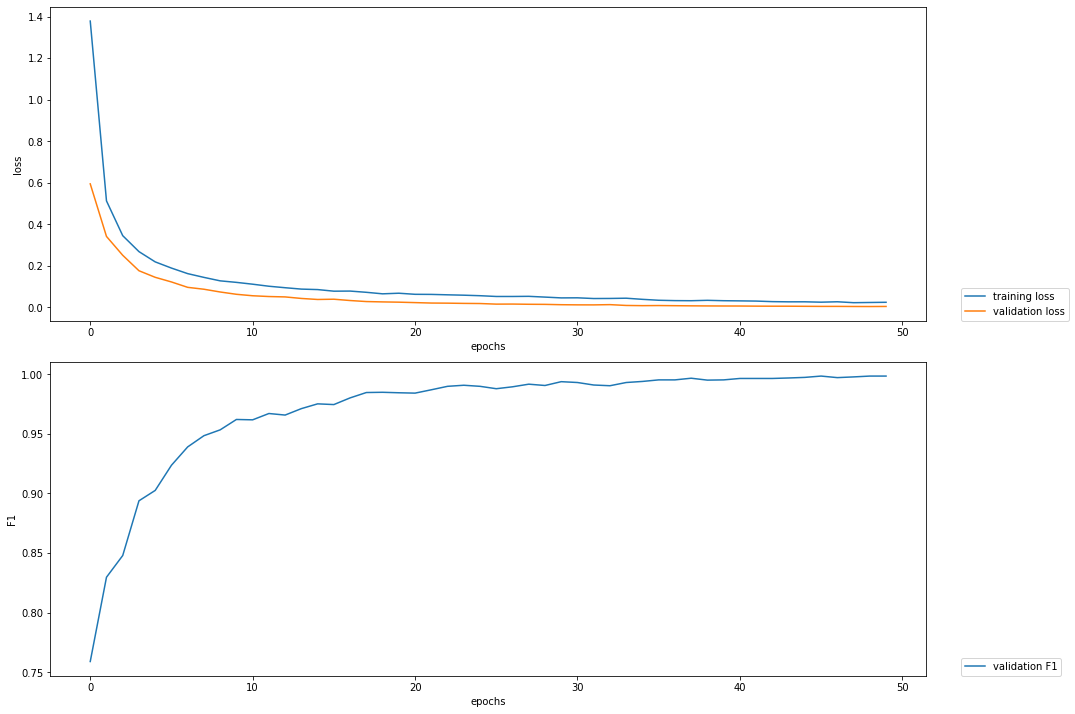

In [ ]:
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_training_curves('../resources/flair-intent-slot/loss.tsv')

## Analysis of the output
It is important to run some analysis of the output of our model in order to gain some insights about good and bad things of the model. A good idea is to extract some correct examples and incorrectly predicted examples. For the slot filing task you can use [the spaCy visualizer for entities](https://spacy.io/usage/visualizers). A example of how to use it you can find in the notebook of __lab 2 (NER with spaCy)__.

In addition, the calculation of a confusion matrix it is very helpful to depict the type of prediction error. It helps to see if there a bias towards a specific set of labels, or there exist some kind confusability between classes (e.g. because class definitions are similar) and so on.  You can find in `scikit-learn` a module to calculate confusion matrices (`sklearn.metrics.confusion_matrix`)

### TO-DO 
- Show some correct and incorrect examples for intent classification and slot filling. 
- Calculate on the development set and show the confusion matrix of your model. 


### Get tags

We get the predicted and gold tags for each task, intent classification and slot filling.

In [16]:
def get_tags(filename):
    gold_tags_intent = []
    pred_tags_intent = []
    gold_tags_slot = []
    pred_tags_slot = []
    with open(filename) as f:
        for line in f.readlines():
            if line != "\n":
                word, gold, pred = line.split()
                if word == "EOS":
                    gold_tags_intent.append(gold)
                    pred_tags_intent.append(pred)
                else:
                    gold_tags_slot.append(gold)
                    pred_tags_slot.append(pred)

    return gold_tags_intent, pred_tags_intent, gold_tags_slot, pred_tags_slot

In [17]:
gold_tags_intent, pred_tags_intent, gold_tags_slot, pred_tags_slot = get_tags("../resources/flair-intent-slot/dev.tsv")

### Confusion matrix

We plot the confusion matrix of intent classification and slot filling. This way, we can have a global picture of all the predictions. We can know how many tags are predicted correctly by looking at the main diagonal. The numbers that are outside of the diagonal are mistakes. Numbers are colored using a logarthmic scale because there are many O tags.

As previous results showed, there are very few mistakes. In intent classification there are only two mistakes. In slot filling there are only 3 errors.

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools
from matplotlib.colors import LogNorm

def plot_confusion_matrix(cm, labels, size, cmap=plt.cm.BuPu):
    """
    This function plots the confusion matrix.
    """
    plt.figure(figsize = (size, size))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect="auto", norm=LogNorm(vmin=0.5, vmax=8846))
    x_tick_marks = np.arange(len(labels))
    y_tick_marks = np.arange(len(labels))
    plt.xticks(x_tick_marks, labels, rotation=90)
    plt.yticks(y_tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

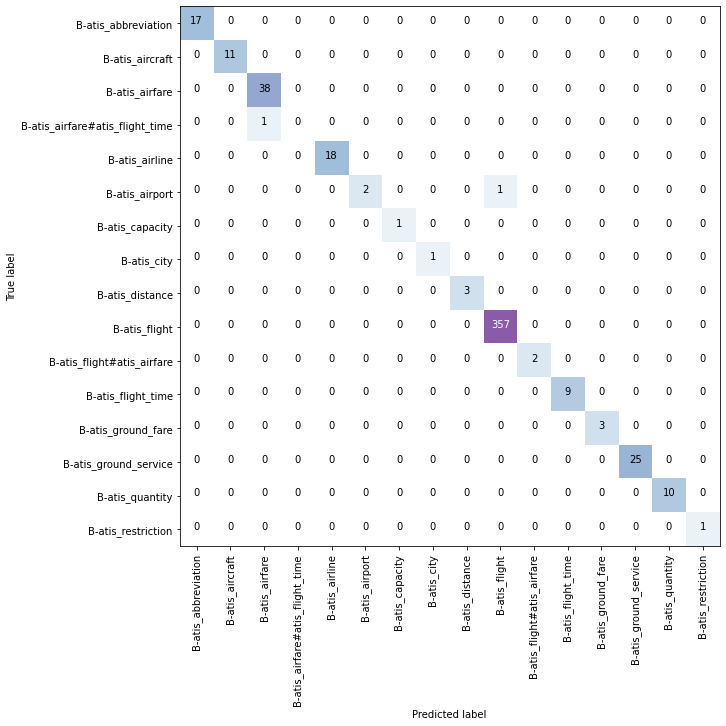

In [19]:
cm_intent = confusion_matrix(gold_tags_intent, pred_tags_intent)
labels_intent = sorted(set(gold_tags_intent))
plot_confusion_matrix(cm_intent, labels_intent, size=10)

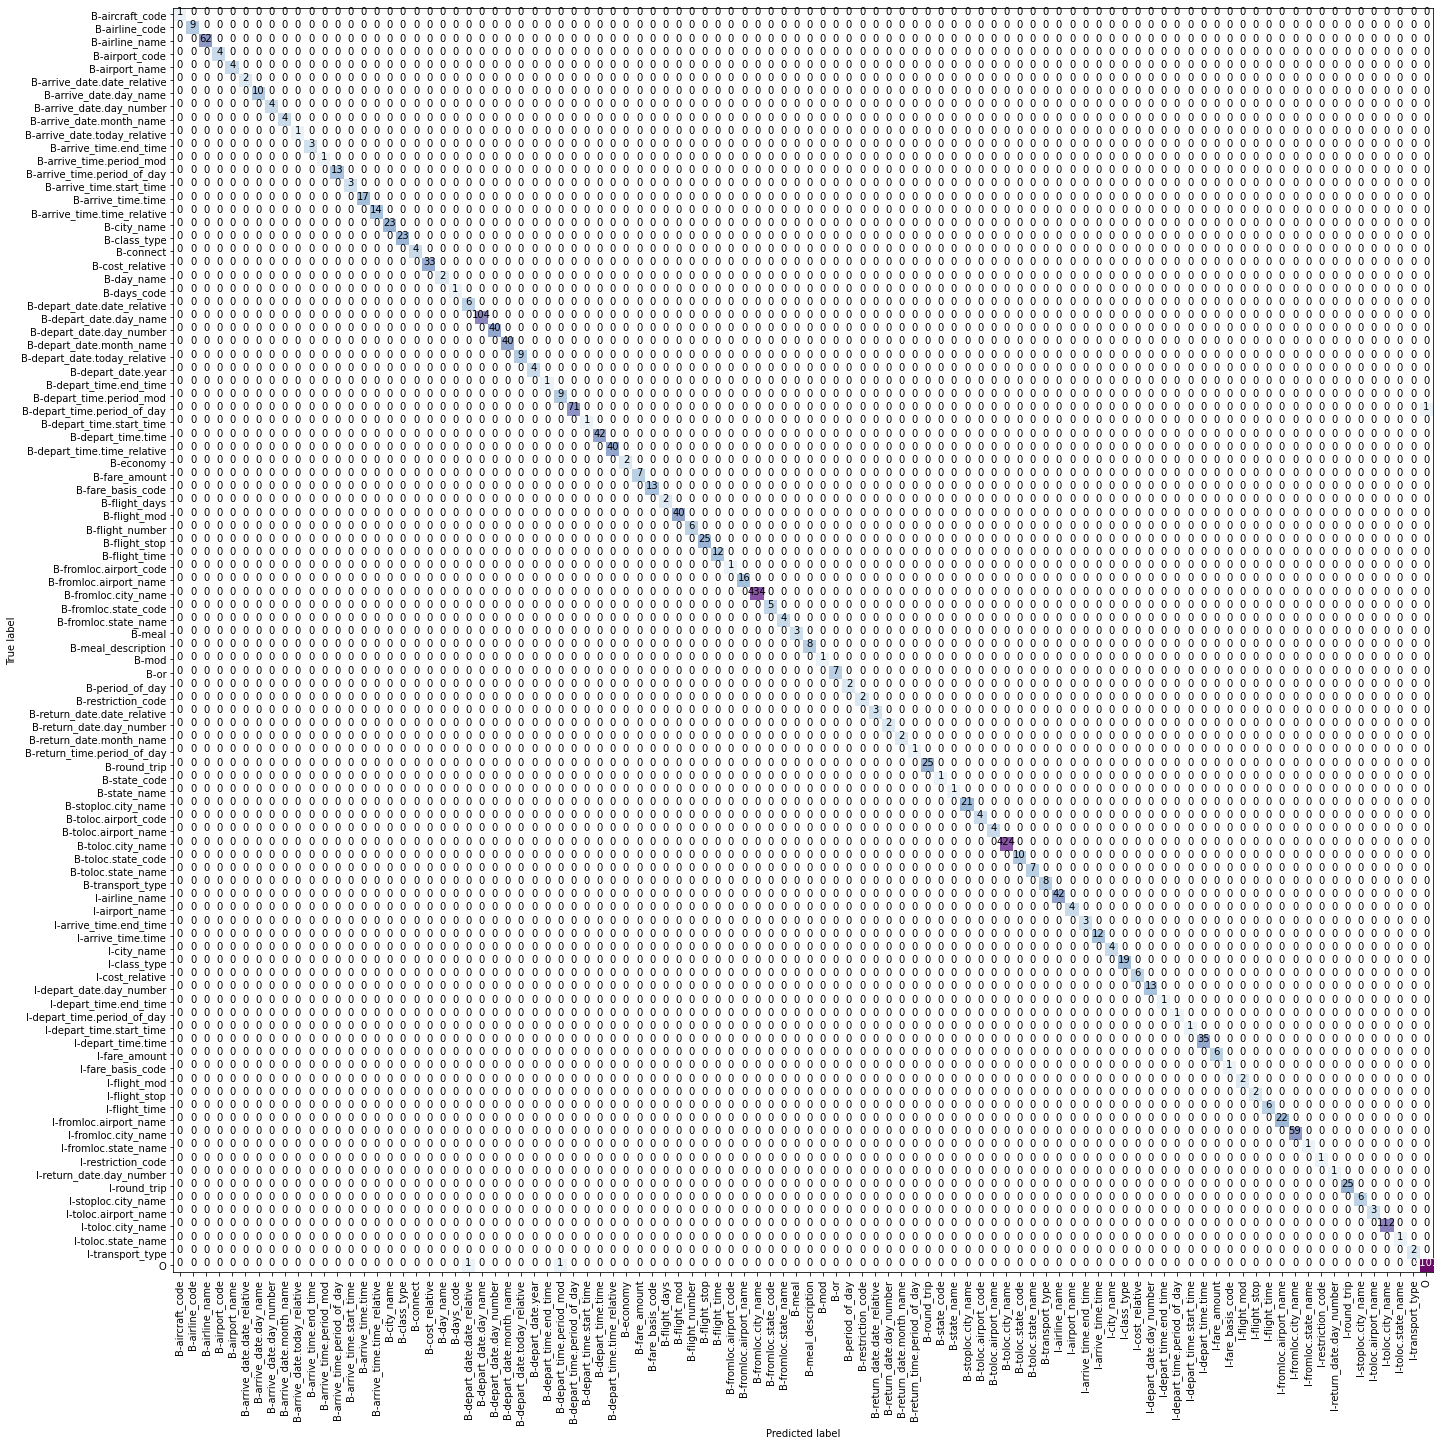

In [20]:
cm_slot = confusion_matrix(gold_tags_slot, pred_tags_slot)
labels_slot = sorted(set(gold_tags_slot))
plot_confusion_matrix(cm_slot, labels_slot, size=20)

### Correct and incorrect examples

We show one correct example and all the incorrect examples for intent and slot.

In [38]:
import pandas as pd
df_dev = pd.read_csv("../resources/flair-intent-slot/dev.tsv", delimiter=" ", header=None, names=["word", "gold", "pred"])
df_dev

,word,gold,pred
0,BOS,O,O
1,i,O,O
2,want,O,O
3,to,O,O
4,fly,O,O
...,...,...,...
6698,that,O,O
6699,connect,B-connect,B-connect
6700,in,O,O
6701,phoenix,B-stoploc.city_name,B-stoploc.city_name


In [24]:
# correct example
df_dev.head(20)

,word,gold,pred
0,BOS,O,O
1,i,O,O
2,want,O,O
3,to,O,O
4,fly,O,O
5,from,O,O
6,boston,B-fromloc.city_name,B-fromloc.city_name
7,at,O,O
8,838,B-depart_time.time,B-depart_time.time
9,am,I-depart_time.time,I-depart_time.time


In [22]:
# incorrect example intent 2958
df_dev[2948:2959]

,word,gold,pred
2948,BOS,O,O
2949,where,O,O
2950,do,O,O
2951,the,O,O
2952,flights,O,O
2953,from,O,O
2954,boston,B-fromloc.city_name,B-fromloc.city_name
2955,to,O,O
2956,oakland,B-toloc.city_name,B-toloc.city_name
2957,stop,B-flight_stop,B-flight_stop


In [23]:
# incorrect example intent 5660
df_dev[5646:5661]

,word,gold,pred
5646,BOS,O,O
5647,show,O,O
5648,me,O,O
5649,the,O,O
5650,costs,O,O
5651,and,O,O
5652,times,B-flight_time,B-flight_time
5653,for,O,O
5654,flights,O,O
5655,from,O,O


In [31]:
# incorrect example slot 2897
df_dev[2883:2900]

,word,gold,pred
2883,BOS,O,O
2884,show,O,O
2885,me,O,O
2886,prices,O,O
2887,and,O,O
2888,times,B-flight_time,B-flight_time
2889,for,O,O
2890,first,B-class_type,B-class_type
2891,class,I-class_type,I-class_type
2892,travel,O,O


In [37]:
# incorrect example slot 227 and 245
# the gold tag in 227 is wrong
df_dev[225:254]

,word,gold,pred
225,BOS,O,O
226,i,O,O
227,am,B-depart_time.period_of_day,O
228,interested,O,O
229,in,O,O
230,booking,O,O
231,an,O,O
232,early,B-depart_time.period_of_day,B-depart_time.period_of_day
233,morning,B-depart_time.period_of_day,B-depart_time.period_of_day
234,flight,O,O
